In [1]:
import pandas as pd
import numpy as np
import time
from pycaret.classification import *

In [44]:
# 새롭게 labeling
def class_labeler(df):
    
    data = df.copy()
    
    data['classes'] = 0

    class1 = data[(data['circ_next_12h']==0) & (data['Annotation']=='no_circ')].index
    data.loc[class1,'classes'] = 0
    
    class2 = data[(data['circ_next_12h']==1) & (data['Annotation']=='no_circ')].index
    data.loc[class2,'classes'] = 1
    
    class3 = data[(data['circ_next_12h']==0) & (data['Annotation']=='circ')].index
    data.loc[class3,'classes'] = 2
    
    class4 = data[(data['circ_next_12h']==1) & (data['Annotation']=='circ')].index
    data.loc[class4,'classes'] = 3
    
    return data

In [45]:
def check_class_ratio(dataset):
    class_ratio = round(np.mean(dataset.classes), 2)
    return class_ratio

def random_split_stay(df, train_ratio, Threshold, n_trial):
    data = df.copy()
    
    search_time = time.time()
    
    for T in range(n_trial):
        array = data.subject_id.unique()
        
        # seed = np.random.randint(0, 10000, 1)
        seed = 1416
        np.random.seed(seed) 
        np.random.shuffle(array)


        split_point = int(train_ratio * len(array))
        stay_for_train, stay_for_test = np.split(array, [split_point])

        

        condition_train = data.subject_id.isin(stay_for_train)
        holdout_train = data[condition_train]

        condition_test = data.subject_id.isin(stay_for_test)
        holdout_test = data[condition_test]
        
        # holdout_test = holdout_test.sort_values(by=['subject_id',  'stay_id', 'Time_since_ICU_admission']) 
        # holdout_train = holdout_train.sort_values(by=['subject_id',  'stay_id', 'Time_since_ICU_admission']) 

        train_class_ratio  = check_class_ratio(holdout_train)
        test_class_ratio  = check_class_ratio(holdout_test)
                
            
        if (train_class_ratio - test_class_ratio) >= Threshold:
            
            break  # 클래스 비율이 모두 threshold 이상일 경우 반복문 종료
        
        if T % 100 == 0:
            print('Trial: ', T)
            
        if T % 10000 == 0:
        
            Threshold = Threshold + 0.05
            print('Threshold 조정 + 0.05, 현재 한계값: {}'.format(Threshold))
        
        if T == 9999:
            print('최대 Trial 달성, 분할 불가')
        
    train = holdout_train.copy()
    test = holdout_test.copy()
    search_time_end = time.time()
    
    trn_class1 = train.classes.value_counts()[0]
    trn_class2 = train.classes.value_counts()[1]
    
    tes_class1 = test.classes.value_counts()[0]
    tes_class2 = test.classes.value_counts()[1]

    
    
    print('train set : test set = {} : {}'.format(train_ratio, 1-train_ratio))
    print('Train set class: ', train.classes.value_counts().sort_index())
    print('Test set class: ', test.classes.value_counts().sort_index())
    print('-'*20)
    print('Train class ratio: {}:{}'.format((trn_class1)/(trn_class1+trn_class2), (trn_class2)/(trn_class1+trn_class2)))
    print('Test class ratio: {}:{}'.format((tes_class1)/(tes_class1+tes_class2), (tes_class2)/(tes_class1+tes_class2)))
    print('-'*20)
    print('Number of trainset patient:', len(train.subject_id.unique()))
    print('Number of testset patient:', len(test.subject_id.unique()))
    print('Number of trainset stay:', len(train.stay_id.unique()))
    print('Number of testset stay:', len(test.stay_id.unique()))
    print('-'*20)
    print('Split seed: ',seed)
    print('train ratio:', train_ratio)
    print('Threshold:', Threshold)
    print('-'*20)
    print('총 소요 시간(초):{}'.format(search_time_end - search_time))
    print('시도한 trial 수: ', T)
    
    return train, test, stay_for_train, stay_for_test

In [407]:
dataset = pd.read_csv('./Data/final/mimic-v_circ12h.csv', index_col = 0)
mimic_df = class_labeler(dataset)

mimic_train_ori, mimic_valid_ori, trn_patient, val_patient = random_split_stay(mimic_df, 0.7, Threshold=0.05, n_trial=1) 
mimic_train_ori = mimic_train_ori[(mimic_train_ori['classes']==0)|(mimic_train_ori['classes']==1)].reset_index(drop=True)
mimic_valid_ori = mimic_valid_ori[(mimic_valid_ori['classes']==0)|(mimic_valid_ori['classes']==1)]

Trial:  0
Threshold 조정 + 0.05, 현재 한계값: 0.1
train set : test set = 0.7 : 0.30000000000000004
Train set class:  0    151394
1     17804
2      5085
3    201749
Name: classes, dtype: int64
Test set class:  0    64313
1     7863
2     2180
3    83776
Name: classes, dtype: int64
--------------------
Train class ratio: 0.8947741699074457:0.10522583009255429
Test class ratio: 0.8910579694081135:0.1089420305918865
--------------------
Number of trainset patient: 4416
Number of testset patient: 1893
Number of trainset stay: 4812
Number of testset stay: 2064
--------------------
Split seed:  1416
train ratio: 0.7
Threshold: 0.1
--------------------
총 소요 시간(초):0.2151796817779541
시도한 trial 수:  0


In [408]:
from tqdm import tqdm
case2isin_stayid = mimic_valid_ori[mimic_valid_ori['classes']==1].stay_id.unique()
search_space = mimic_df[mimic_df.stay_id.isin(case2isin_stayid)][['subject_id', 'stay_id','Time_since_ICU_admission' ,'Annotation', 'classes']]
search_stayid = search_space.stay_id.unique()

mimic_valid_ori['Time_since_FirstCirc'] = 'blank'

for i in tqdm(search_stayid):
    mask = mimic_valid_ori['stay_id']==i
    
    sub_space = search_space[search_space['stay_id']==i]
    first_circ_index = sub_space[sub_space['Annotation']=='circ'].index[0]
    basis_time = sub_space.loc[first_circ_index, 'Time_since_ICU_admission']

    mimic_valid_ori.loc[mask, 'Time_since_FirstCirc'] = basis_time - mimic_valid_ori.loc[mask, 'Time_since_ICU_admission']

100%|██████████| 483/483 [00:00<00:00, 1749.99it/s]


In [411]:
mimic_valid_ori = mimic_valid_ori.reset_index(drop=True)

In [415]:
embset = pd.read_csv('./Data/final/embedding_data.csv', index_col = 0)
embset = embset.rename(columns ={'0.1':'classes'})
# mimic_df_emb = class_labeler(embset)

mimic_train_emb, mimic_valid_emb, trn_patient, val_patient = random_split_stay(embset, 0.7, Threshold=0.05, n_trial=1) 
mimic_train_emb = mimic_train_emb[(mimic_train_emb['classes']==0)|(mimic_train_emb['classes']==1)].reset_index(drop=True)
mimic_valid_emb = mimic_valid_emb[(mimic_valid_emb['classes']==0)|(mimic_valid_emb['classes']==1)].reset_index(drop=True)

Trial:  0
Threshold 조정 + 0.05, 현재 한계값: 0.1
train set : test set = 0.7 : 0.30000000000000004
Train set class:  0    151394
1     17804
2      5085
3    201749
Name: classes, dtype: int64
Test set class:  0    64313
1     7863
2     2180
3    83776
Name: classes, dtype: int64
--------------------
Train class ratio: 0.8947741699074457:0.10522583009255429
Test class ratio: 0.8910579694081135:0.1089420305918865
--------------------
Number of trainset patient: 4416
Number of testset patient: 1893
Number of trainset stay: 4812
Number of testset stay: 2064
--------------------
Split seed:  1416
train ratio: 0.7
Threshold: 0.1
--------------------
총 소요 시간(초):0.13399982452392578
시도한 trial 수:  0


In [419]:
mimic_valid_emb['Time_since_FirstCirc'] = mimic_valid_ori['Time_since_FirstCirc'].copy()

In [473]:
# original space

input_space_clf_setting = setup(data = mimic_train_ori.drop(['subject_id', 'stay_id', 'hadm_id','Annotation','circ_next_12h'], axis = 1), target = 'classes',
                                test_data = mimic_valid_ori.drop(['subject_id', 'stay_id', 'hadm_id','Annotation','circ_next_12h','Time_since_FirstCirc'], axis = 1), index=False, session_id = 123)

,Description,Value
0,Session id,123
1,Target,classes
2,Target type,Binary
3,Original data shape,"(241374, 118)"
4,Transformed data shape,"(241374, 118)"
5,Transformed train set shape,"(169198, 118)"
6,Transformed test set shape,"(72176, 118)"
7,Numeric features,117
8,Preprocess,True
9,Imputation type,simple


In [421]:
best = compare_models(include = ['svm','lr', 'dt', 'lightgbm', 'xgboost'], cross_validation=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9036,0.9060,0.4173,0.5797,0.4852,0.4336,0.4407,0.2500
lr,Logistic Regression,0.8963,0.8596,0.2990,0.5433,0.3857,0.3342,0.3521,0.2400
xgboost,Extreme Gradient Boosting,0.8959,0.8982,0.4271,0.5275,0.4720,0.4150,0.4178,0.2600
svm,SVM - Linear Kernel,0.8668,0.6436,0.3581,0.3814,0.3694,0.2950,0.2952,0.2300
dt,Decision Tree Classifier,0.8547,0.6720,0.4383,0.3622,0.3966,0.3149,0.3168,0.2400


Processing:   0%|          | 0/25 [00:00<?, ?it/s]

In [474]:
test_data = mimic_valid_ori.drop(['subject_id', 'stay_id', 'hadm_id', 'Time_since_FirstCirc'], axis = 1)

In [475]:
lightgbm = create_model('lightgbm', cross_validation=False, learning_rate=0.1)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.9036,0.9060,0.4173,0.5797,0.4852,0.4336,0.4407


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [476]:
dt = create_model('dt', cross_validation=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.8547,0.6720,0.4383,0.3622,0.3966,0.3149,0.3168


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [477]:
xgboost = create_model('xgboost', cross_validation=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.8959,0.8982,0.4271,0.5275,0.4720,0.4150,0.4178


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [478]:
lr = create_model('lr', cross_validation=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.8963,0.8596,0.2990,0.5433,0.3857,0.3342,0.3521


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [479]:
svm = create_model('svm', cross_validation=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.8668,0.6436,0.3581,0.3814,0.3694,0.2950,0.2952


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [480]:
predictions_1 = predict_model(lightgbm, data=test_data, raw_score=True)
predictions_2 = predict_model(dt, data=test_data, raw_score=True)
predictions_3 = predict_model(xgboost, data=test_data, raw_score=True)
predictions_4 = predict_model(lr, data=test_data, raw_score=True)
predictions_5 = predict_model(svm, data=test_data, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9036,0.9060,0.4173,0.5797,0.4852,0.4336,0.4407


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.8547,0.6720,0.4383,0.3622,0.3966,0.3149,0.3168


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.8959,0.8982,0.4271,0.5275,0.4720,0.4150,0.4178


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8963,0.8596,0.2990,0.5433,0.3857,0.3342,0.3521


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.8668,0.6436,0.3581,0.3814,0.3694,0.2950,0.2952


In [429]:
predictions_1 = make_mapper(predictions_1)
predictions_2 = make_mapper(predictions_2)
predictions_3 = make_mapper(predictions_3)
predictions_4 = make_mapper(predictions_4)
predictions_5 = make_mapper(predictions_5)

In [430]:
predictions_1 = group_mapper(predictions_1)
predictions_2 = group_mapper(predictions_2)
predictions_3 = group_mapper(predictions_3)
predictions_4 = group_mapper(predictions_4)
predictions_5 = group_mapper(predictions_5)

In [331]:
lgbmioc = IoC(precision=0.5797, recall=0.4173, beta= 2)
lrioc = IoC(precision=0.5405, recall=0.2962, beta= 2)
xgbioc = IoC(precision=0.5275, recall=0.4271, beta= 2)
dtioc = IoC(precision=0.3622, recall=0.4383, beta= 2)
svmioc = IoC(precision=0.2789, recall=0.6275, beta= 2)

print('ioc(beta=2)')
print('light gbm: ', lgbmioc)
print('dtL ', dtioc)
print('xgbioc', xgbioc)
print('lrioc', lrioc)
print('svmioc', svmioc)

ioc(beta=2)
light gbm:  0.44206865611637
dtL  0.4206249271368767
xgbioc 0.4440015174805881
lrioc 0.32563684810023596
svmioc 0.502007199816419


In [363]:
(lgbmioc + dtioc + xgbioc + lrioc + svmioc)/5

0.4268678297300979

In [332]:
lgbmioc15 = IoC(precision=0.5797, recall=0.4173, beta= 1.5)
lrioc15 = IoC(precision=0.5405, recall=0.2962, beta= 1.5)
xgbioc15 = IoC(precision=0.5275, recall=0.4271, beta= 1.5)
dtioc15 = IoC(precision=0.3622, recall=0.4383, beta= 1.5)
svmioc15 = IoC(precision=0.2789, recall=0.6275, beta= 1.5)

In [333]:
print('ioc(beta=2)')
print('light gbm: ', lgbmioc15)
print('dtL ', dtioc15)
print('xgbioc', xgbioc15)
print('lrioc', lrioc15)
print('svmioc', svmioc15)

ioc(beta=2)
light gbm:  0.4566636941842736
dtL  0.41168549371633756
xgbioc 0.4536684660543069
lrioc 0.34404795596184684
svmioc 0.4532034720423896


In [364]:
(lgbmioc15 + dtioc15 + xgbioc15 + lrioc15 + svmioc15)/5

0.42385381639183084

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


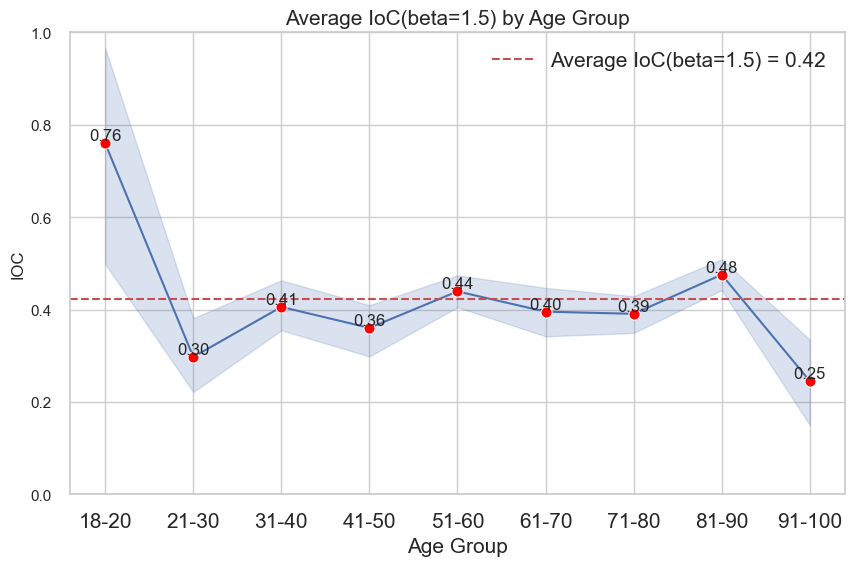

In [365]:
predictions_model1 = predictions_1.copy()
predictions_model2 = predictions_2.copy()
predictions_model3 = predictions_3.copy()
predictions_model4 = predictions_4.copy()
predictions_model5 = predictions_5.copy()

# 각 모델의 예측 결과를 저장하는 데이터프레임 목록 생성
model_predictions = [predictions_model1, predictions_model2, predictions_model3, predictions_model4, predictions_model5]
model_names = ['lgbm', 'dt', 'xgboost', 'lr', 'svm']

# 빈 리스트를 만들어 나이 그룹과 해당 그룹의 IOC 값을 저장
age_groups = []
IOC_scores = []
model_labels = []

# 모델 목록을 반복하면서 각 모델에 대한 성능 메트릭 계산
for model_name, predictions in zip(model_names, model_predictions):
    data = predictions[['classes', 'prediction_label', 'Age_Group']]
    unique_age_groups = data['Age_Group'].unique()
    unique_age_groups = sorted(unique_age_groups)
    
    for age_group in unique_age_groups:
        subset = data[data['Age_Group'] == age_group]
        recall = recall_score(subset['classes'], subset['prediction_label'])
        precision = precision_score(subset['classes'], subset['prediction_label'])
        ioc = IoC(precision, recall, 1.5)
        age_groups.append(age_group)
        IOC_scores.append(ioc)
        model_labels.append(model_name)

# 데이터프레임으로 변환
data = pd.DataFrame({'Age_Group': age_groups, 'IOC': IOC_scores, 'Model': model_labels})

# 그래프 그리기 (포인트 플롯)
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='Age_Group', y='IOC', marker='o', markersize=8, markerfacecolor='red')
plt.xlabel('Age Group', fontsize = 15)
plt.ylabel('IOC')
plt.title('Average IoC(beta=1.5) by Age Group', fontsize=15)
plt.xticks(rotation=0, fontsize = 15)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='upper right')  # 범례 표시

totalIOC = 0.42385381639183084
plt.axhline(y=totalIOC, color='r', linestyle='--', label=f'Average IoC(beta=1.5) = {totalIOC:.2f}')
plt.legend(loc='upper right', fontsize = 15)  # 범례 표시
# 각 그룹별로 IOC의 평균값을 계산하고 노출
average_ioc = data.groupby(['Age_Group'])['IOC'].mean().reset_index()
for i, row in average_ioc.iterrows():
    x_position = unique_age_groups.index(row['Age_Group'])
    plt.text(x_position, row['IOC'], f"{row['IOC']:.2f}", ha='center', va='bottom')

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


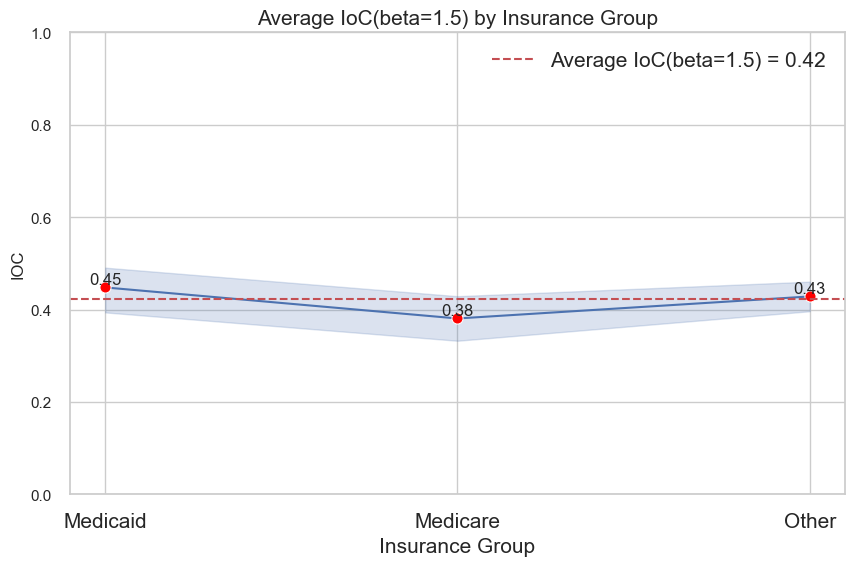

In [366]:
predictions_model1 = predictions_1.copy()
predictions_model2 = predictions_2.copy()
predictions_model3 = predictions_3.copy()
predictions_model4 = predictions_4.copy()
predictions_model5 = predictions_5.copy()

# 각 모델의 예측 결과를 저장하는 데이터프레임 목록 생성
model_predictions = [predictions_model1, predictions_model2, predictions_model3, predictions_model4, predictions_model5]
model_names = ['lgbm', 'dt', 'xgboost', 'lr', 'svm']

# 빈 리스트를 만들어 나이 그룹과 해당 그룹의 IOC 값을 저장
age_groups = []
IOC_scores = []
model_labels = []

# 모델 목록을 반복하면서 각 모델에 대한 성능 메트릭 계산
for model_name, predictions in zip(model_names, model_predictions):
    data = predictions[['classes', 'prediction_label', 'insurance_Group']]
    unique_age_groups = data['insurance_Group'].unique()
    unique_age_groups = sorted(unique_age_groups)
    
    for age_group in unique_age_groups:
        subset = data[data['insurance_Group'] == age_group]
        recall = recall_score(subset['classes'], subset['prediction_label'])
        precision = precision_score(subset['classes'], subset['prediction_label'])
        ioc = IoC(precision, recall, 1.5)
        age_groups.append(age_group)
        IOC_scores.append(ioc)
        model_labels.append(model_name)

# 데이터프레임으로 변환
data = pd.DataFrame({'insurance_Group': age_groups, 'IOC': IOC_scores, 'Model': model_labels})

# 그래프 그리기 (포인트 플롯)
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='insurance_Group', y='IOC', marker='o', markersize=8, markerfacecolor='red')
plt.xlabel('Insurance Group', fontsize=15)
plt.ylabel('IOC')
plt.title('Average IoC(beta=1.5) by Insurance Group', fontsize=15)
plt.xticks(rotation=0, fontsize=15)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='upper right', fontsize=15)  # 범례 표시

totalIOC = 0.42385381639183084
plt.axhline(y=totalIOC, color='r', linestyle='--', label=f'Average IoC(beta=1.5) = {totalIOC:.2f}')
plt.legend(loc='upper right', fontsize=15)  # 범례 표시
# 각 그룹별로 IOC의 평균값을 계산하고 노출
average_ioc = data.groupby(['insurance_Group'])['IOC'].mean().reset_index()
for i, row in average_ioc.iterrows():
    x_position = unique_age_groups.index(row['insurance_Group'])
    plt.text(x_position, row['IOC'], f"{row['IOC']:.2f}", ha='center', va='bottom')

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


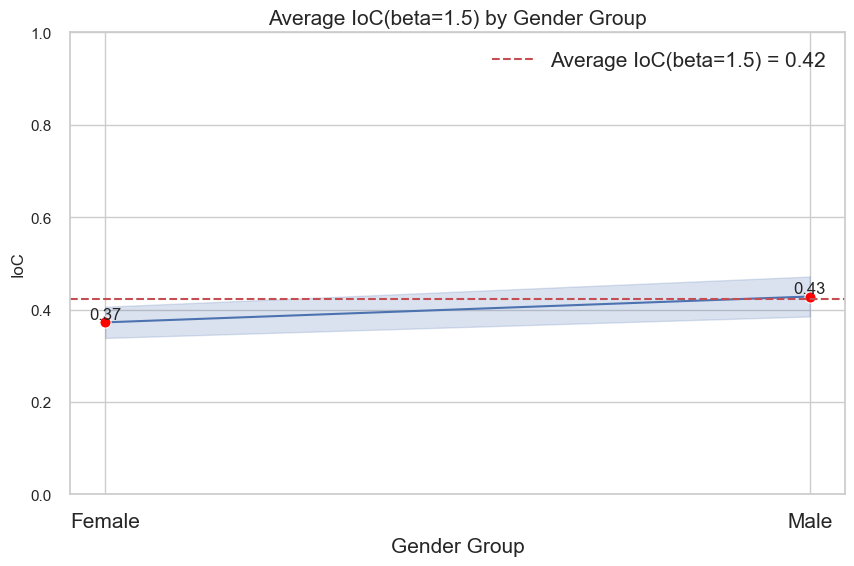

In [367]:
#gender_Group

predictions_model1 = predictions_1.copy()
predictions_model2 = predictions_2.copy()
predictions_model3 = predictions_3.copy()
predictions_model4 = predictions_4.copy()
predictions_model5 = predictions_5.copy()

# 각 모델의 예측 결과를 저장하는 데이터프레임 목록 생성
model_predictions = [predictions_model1, predictions_model2, predictions_model3, predictions_model4, predictions_model5]
model_names = ['lgbm', 'dt', 'xgboost', 'lr', 'svm']

# 빈 리스트를 만들어 나이 그룹과 해당 그룹의 IOC 값을 저장
age_groups = []
IOC_scores = []
model_labels = []

# 모델 목록을 반복하면서 각 모델에 대한 성능 메트릭 계산
for model_name, predictions in zip(model_names, model_predictions):
    data = predictions[['classes', 'prediction_label', 'gender_Group']]
    unique_age_groups = data['gender_Group'].unique()
    unique_age_groups = sorted(unique_age_groups)
    
    for age_group in unique_age_groups:
        subset = data[data['gender_Group'] == age_group]
        recall = recall_score(subset['classes'], subset['prediction_label'])
        precision = precision_score(subset['classes'], subset['prediction_label'])
        ioc = IoC(precision, recall, 1.5)
        age_groups.append(age_group)
        IOC_scores.append(ioc)
        model_labels.append(model_name)

# 데이터프레임으로 변환
data = pd.DataFrame({'gender_Group': age_groups, 'IOC': IOC_scores, 'Model': model_labels})

# 그래프 그리기 (포인트 플롯)
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='gender_Group', y='IOC', marker='o', markersize=8, markerfacecolor='red')
plt.xlabel('Gender Group', fontsize=15)
plt.ylabel('IoC')
plt.title('Average IoC(beta=1.5) by Gender Group', fontsize=15)
plt.xticks(rotation=0, fontsize=15)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='upper right')  # 범례 표시

totalIOC = 0.42385381639183084
plt.axhline(y=totalIOC, color='r', linestyle='--', label=f'Average IoC(beta=1.5) = {totalIOC:.2f}')
plt.legend(loc='upper right', fontsize= 15)  # 범례 표시
# 각 그룹별로 IOC의 평균값을 계산하고 노출
average_ioc = data.groupby(['gender_Group'])['IOC'].mean().reset_index()
for i, row in average_ioc.iterrows():
    x_position = unique_age_groups.index(row['gender_Group'])
    plt.text(x_position, row['IOC'], f"{row['IOC']:.2f}", ha='center', va='bottom')

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
posx and posy should be finite values
posx and posy should be finite values


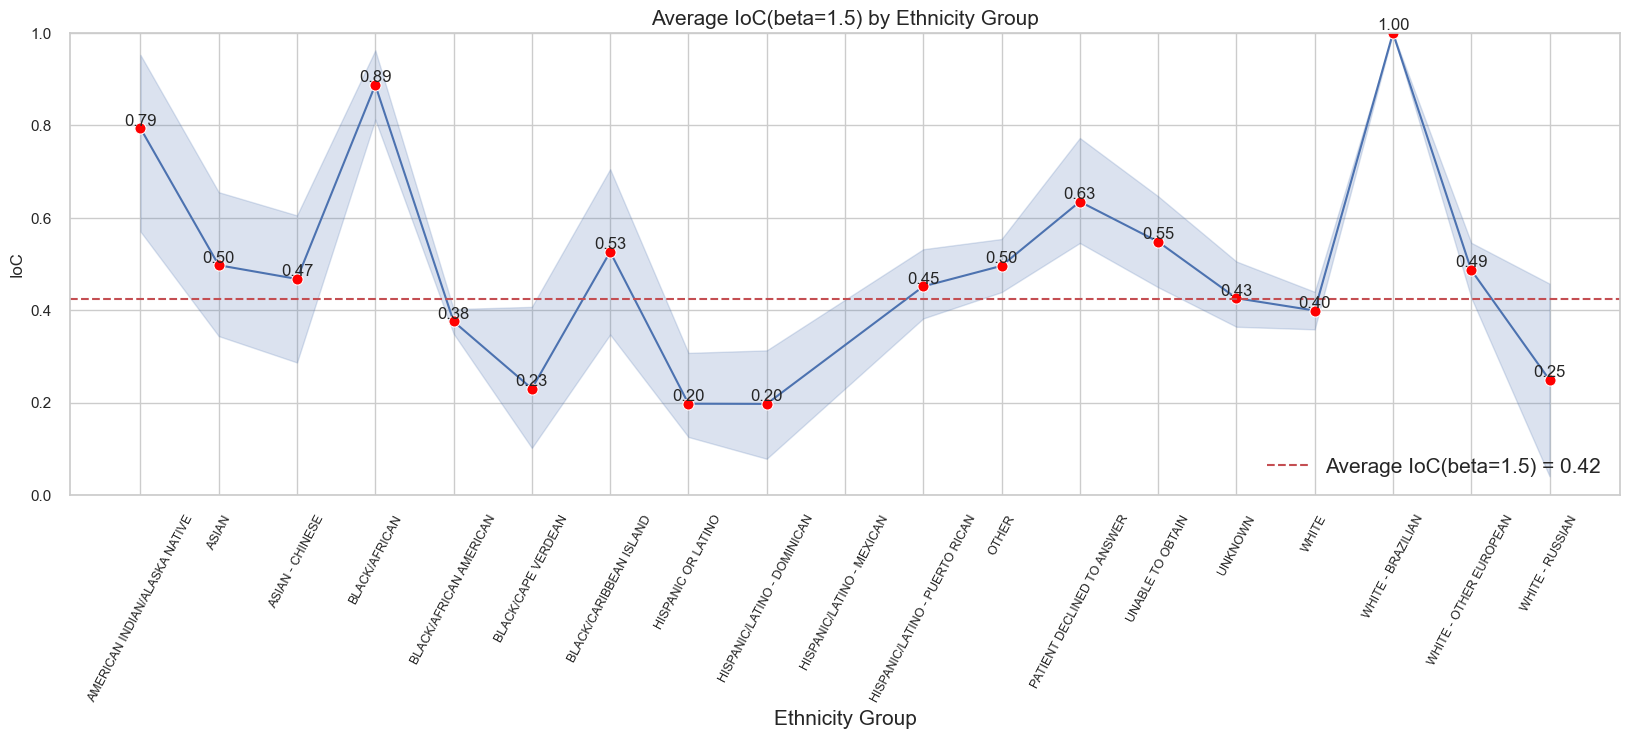

In [368]:
predictions_model1 = predictions_1.copy()
predictions_model2 = predictions_2.copy()
predictions_model3 = predictions_3.copy()
predictions_model4 = predictions_4.copy()
predictions_model5 = predictions_5.copy()

# 각 모델의 예측 결과를 저장하는 데이터프레임 목록 생성
model_predictions = [predictions_model1, predictions_model2, predictions_model3, predictions_model4, predictions_model5]
model_names = ['lgbm', 'dt', 'xgboost', 'lr', 'svm']

# 빈 리스트를 만들어 나이 그룹과 해당 그룹의 IOC 값을 저장
age_groups = []
IOC_scores = []
model_labels = []

# 모델 목록을 반복하면서 각 모델에 대한 성능 메트릭 계산
for model_name, predictions in zip(model_names, model_predictions):
    data = predictions[['classes', 'prediction_label', 'ethnicity_Group']]
    unique_age_groups = ['AMERICAN INDIAN/ALASKA NATIVE', 'ASIAN', 'ASIAN - CHINESE',
       'BLACK/AFRICAN', 'BLACK/AFRICAN AMERICAN', 'BLACK/CAPE VERDEAN',
       'BLACK/CARIBBEAN ISLAND', 'HISPANIC OR LATINO',
       'HISPANIC/LATINO - DOMINICAN', 'HISPANIC/LATINO - MEXICAN',
       'HISPANIC/LATINO - PUERTO RICAN', 'OTHER',
       'PATIENT DECLINED TO ANSWER', 'UNABLE TO OBTAIN', 'UNKNOWN',
       'WHITE', 'WHITE - BRAZILIAN', 'WHITE - OTHER EUROPEAN',
       'WHITE - RUSSIAN']
    unique_age_groups = sorted(unique_age_groups)
    
    for age_group in unique_age_groups:
        subset = data[data['ethnicity_Group'] == age_group]
        recall = recall_score(subset['classes'], subset['prediction_label'])
        precision = precision_score(subset['classes'], subset['prediction_label'])
        ioc = IoC(precision, recall, 1.5)
        age_groups.append(age_group)
        IOC_scores.append(ioc)
        model_labels.append(model_name)

# 데이터프레임으로 변환
data = pd.DataFrame({'ethnicity_Group': age_groups, 'IOC': IOC_scores, 'Model': model_labels})
plt.figure(figsize=(20, 6))
# 그래프 그리기 (포인트 플롯)
sns.lineplot(data=data, x='ethnicity_Group', y='IOC', marker='o', markersize=8, markerfacecolor='red')
plt.xlabel('Ethnicity Group',fontsize=15)
plt.ylabel('IoC')
plt.title('Average IoC(beta=1.5) by Ethnicity Group', fontsize=15)
plt.xticks(rotation=62,fontsize=9)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='upper right')  # 범례 표시

totalIOC = 0.42385381639183084
plt.axhline(y=totalIOC, color='r', linestyle='--', label=f'Average IoC(beta=1.5) = {totalIOC:.2f}')
plt.legend(loc='lower right', fontsize=15)  # 범례 표시
# 각 그룹별로 IOC의 평균값을 계산하고 노출
average_ioc = data.groupby(['ethnicity_Group'])['IOC'].mean().reset_index()
for i, row in average_ioc.iterrows():
    x_position = unique_age_groups.index(row['ethnicity_Group'])
    plt.text(x_position, row['IOC'], f"{row['IOC']:.2f}", ha='center', va='bottom')

plt.show()

In [431]:
information = mimic_valid_ori[['subject_id','Age','gender','ethnicity','insurance', 'Time_since_ICU_admission', 'Time_since_FirstCirc']]

In [ ]:
# 나이를 10년 단위로 그룹화
time_groups = pd.cut(information['Time_since_ICU_admission'], bins=[0, 1, 2, 4, 8, 24, 48, 71.5], labels=['1h', '2h', '4h', '8h', '24h', '2d', '3d~'])
# time_groups = pd.cut(information['Time_since_ICU_admission'], bins=[0, 1, 2, 4, 8, 24, 48, 71.5], labels=['1h', '2h', '4h', '8h', '24h', '2d~'])

# 'Age_Group' 열을 데이터프레임에 추가
information['time_Group'] = time_groups

predictions_model1['time_Group'] = time_groups
predictions_model2['time_Group'] = time_groups
predictions_model3['time_Group'] = time_groups
predictions_model4['time_Group'] = time_groups
predictions_model5['time_Group'] = time_groups

In [482]:
predictions_model1['Time_since_FirstCirc'] = information['Time_since_FirstCirc'].values.copy()
predictions_model2['Time_since_FirstCirc'] = information['Time_since_FirstCirc'].values.copy()
predictions_model3['Time_since_FirstCirc'] = information['Time_since_FirstCirc'].values.copy()
predictions_model4['Time_since_FirstCirc'] = information['Time_since_FirstCirc'].values.copy()
predictions_model5['Time_since_FirstCirc'] = information['Time_since_FirstCirc'].values.copy()

for_newplot_1_o = predictions_model1[~(predictions_model1['Time_since_FirstCirc']=='blank')].copy()
for_newplot_2_o = predictions_model2[~(predictions_model2['Time_since_FirstCirc']=='blank')].copy()
for_newplot_3_o = predictions_model3[~(predictions_model3['Time_since_FirstCirc']=='blank')].copy()
for_newplot_4_o = predictions_model4[~(predictions_model4['Time_since_FirstCirc']=='blank')].copy()
for_newplot_5_o = predictions_model5[~(predictions_model5['Time_since_FirstCirc']=='blank')].copy()

for_newplot_1_o = for_newplot_1_o[for_newplot_1_o['Time_since_FirstCirc']>=0]
for_newplot_2_o = for_newplot_2_o[for_newplot_2_o['Time_since_FirstCirc']>=0]
for_newplot_3_o = for_newplot_3_o[for_newplot_3_o['Time_since_FirstCirc']>=0]
for_newplot_4_o = for_newplot_4_o[for_newplot_4_o['Time_since_FirstCirc']>=0]
for_newplot_5_o = for_newplot_5_o[for_newplot_5_o['Time_since_FirstCirc']>=0]

alarm_groups = pd.cut(for_newplot_1_o['Time_since_FirstCirc'],bins = [0, 2, 4, 8, 12, 24], labels=['0h', '2h', '4h', '8h', '12h'])

for_newplot_1_o['alarm_Group'] = alarm_groups
for_newplot_2_o['alarm_Group'] = alarm_groups
for_newplot_3_o['alarm_Group'] = alarm_groups
for_newplot_4_o['alarm_Group'] = alarm_groups
for_newplot_5_o['alarm_Group'] = alarm_groups

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


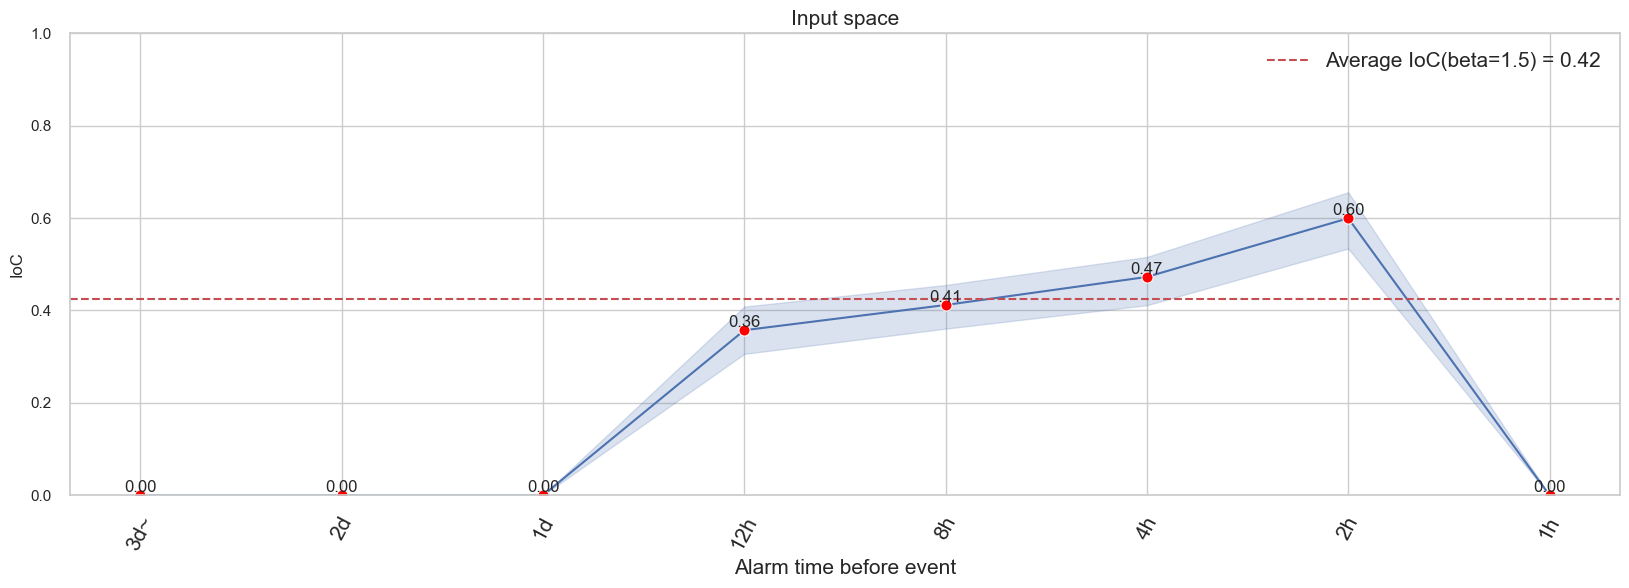

In [512]:
# 각 모델의 예측 결과를 저장하는 데이터프레임 목록 생성
model_predictions = [for_newplot_1_o, for_newplot_2_o, for_newplot_3_o, for_newplot_4_o, for_newplot_5_o]
model_names = ['lgbm', 'dt', 'xgboost', 'lr', 'svm']

# 빈 리스트를 만들어 나이 그룹과 해당 그룹의 IOC 값을 저장
age_groups = []
IOC_scores = []
model_labels = []

# 모델 목록을 반복하면서 각 모델에 대한 성능 메트릭 계산
for model_name, predictions in zip(model_names, model_predictions):
    data = predictions[['classes', 'prediction_label', 'alarm_Group']]
    unique_age_groups = ['3d~', '2d', '1d', '12h', '8h', '4h', '2h', '1h']
    # unique_age_groups = sorted(unique_age_groups)
    
    for age_group in unique_age_groups:
        subset = data[data['alarm_Group'] == age_group]
        recall = recall_score(subset['classes'], subset['prediction_label'])
        precision = precision_score(subset['classes'], subset['prediction_label'])
        ioc = IoC(precision, recall, 1.5)
        age_groups.append(age_group)
        IOC_scores.append(recall)
        model_labels.append(model_name)

# 데이터프레임으로 변환
data = pd.DataFrame({'alarm_Group': age_groups, 'IOC': IOC_scores, 'Model': model_labels})
plt.figure(figsize=(20, 6))
# 그래프 그리기 (포인트 플롯)
sns.lineplot(data=data, x='alarm_Group', y='IOC', marker='o', markersize=8, markerfacecolor='red')
# sns.lineplot(x=data['time_Group'], y=['1h(428/677)', '2h(367/591)', '4h(397/996)', '8h(773/1745)', '24h(2256/8780)', '2d(2184/23700)', '3d~(1029/34297)'], marker='o', markersize=8, markerfacecolor='red')
plt.xlabel('Alarm time before event', fontsize=15)
plt.ylabel('IoC')
plt.title('Input space', fontsize=15)
plt.xticks(rotation=62,fontsize=15)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='upper right')  # 범례 표시

# totalIOC = 0.47769309537780436
plt.axhline(y=totalIOC, color='r', linestyle='--', label=f'Average IoC(beta=1.5) = {totalIOC:.2f}')
plt.legend(loc='upper right', fontsize=15)  # 범례 표시
# 각 그룹별로 IOC의 평균값을 계산하고 노출
average_ioc = data.groupby(['alarm_Group'])['IOC'].mean().reset_index()
for i, row in average_ioc.iterrows():
    x_position = unique_age_groups.index(row['alarm_Group'])
    plt.text(x_position, row['IOC'], f"{row['IOC']:.2f}", ha='center', va='bottom')

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


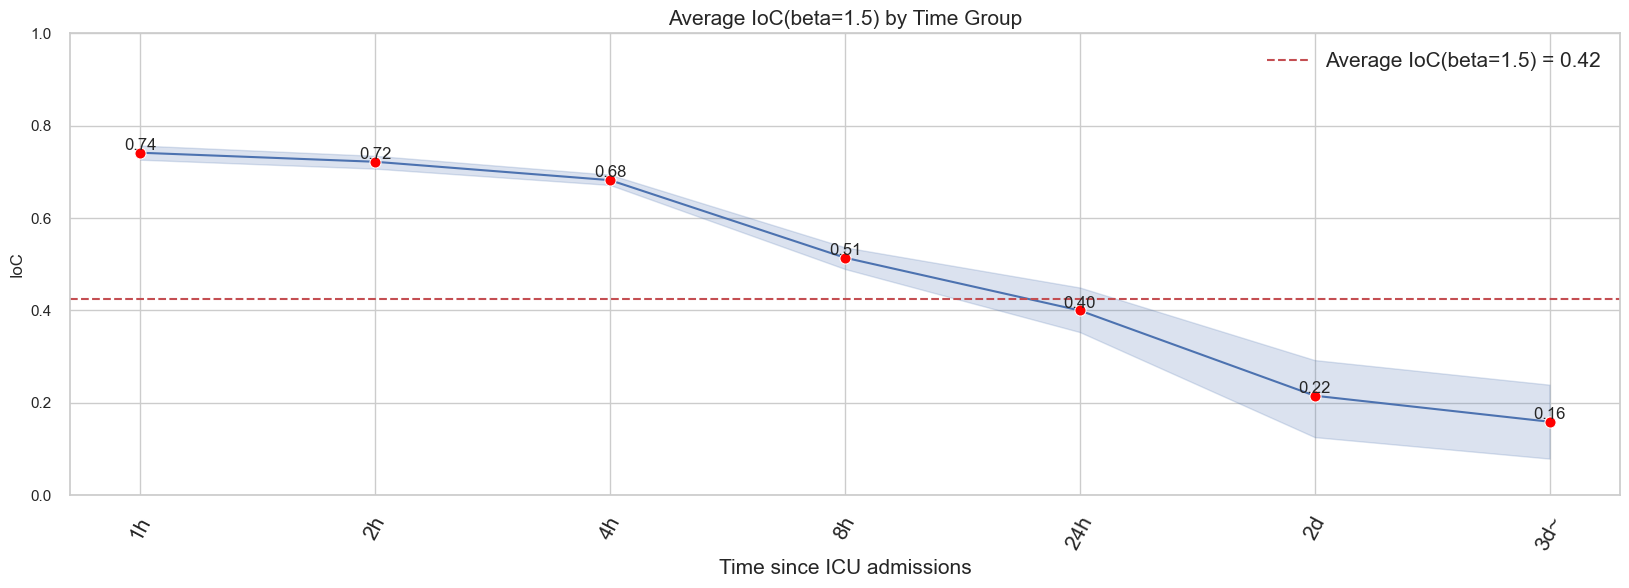

In [370]:
# 각 모델의 예측 결과를 저장하는 데이터프레임 목록 생성
model_predictions = [predictions_model1, predictions_model2, predictions_model3, predictions_model4, predictions_model5]
model_names = ['lgbm', 'dt', 'xgboost', 'lr', 'svm']

# 빈 리스트를 만들어 나이 그룹과 해당 그룹의 IOC 값을 저장
age_groups = []
IOC_scores = []
model_labels = []

# 모델 목록을 반복하면서 각 모델에 대한 성능 메트릭 계산
for model_name, predictions in zip(model_names, model_predictions):
    data = predictions[['classes', 'prediction_label', 'time_Group']]
    unique_age_groups = ['1h', '2h', '4h', '8h', '24h', '2d', '3d~']
    # unique_age_groups = sorted(unique_age_groups)
    
    for age_group in unique_age_groups:
        subset = data[data['time_Group'] == age_group]
        recall = recall_score(subset['classes'], subset['prediction_label'])
        precision = precision_score(subset['classes'], subset['prediction_label'])
        ioc = IoC(precision, recall, 1.5)
        age_groups.append(age_group)
        IOC_scores.append(ioc)
        model_labels.append(model_name)

# 데이터프레임으로 변환
data = pd.DataFrame({'time_Group': age_groups, 'IOC': IOC_scores, 'Model': model_labels})
plt.figure(figsize=(20, 6))
# 그래프 그리기 (포인트 플롯)
sns.lineplot(data=data, x='time_Group', y='IOC', marker='o', markersize=8, markerfacecolor='red')
# sns.lineplot(x=data['time_Group'], y=['1h(428/677)', '2h(367/591)', '4h(397/996)', '8h(773/1745)', '24h(2256/8780)', '2d(2184/23700)', '3d~(1029/34297)'], marker='o', markersize=8, markerfacecolor='red')
plt.xlabel('Time since ICU admissions', fontsize=15)
plt.ylabel('IoC')
plt.title('Average IoC(beta=1.5) by Time Group', fontsize=15)
plt.xticks(rotation=62,fontsize=15)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='upper right')  # 범례 표시

# totalIOC = 0.47769309537780436
plt.axhline(y=totalIOC, color='r', linestyle='--', label=f'Average IoC(beta=1.5) = {totalIOC:.2f}')
plt.legend(loc='upper right', fontsize=15)  # 범례 표시
# 각 그룹별로 IOC의 평균값을 계산하고 노출
average_ioc = data.groupby(['time_Group'])['IOC'].mean().reset_index()
for i, row in average_ioc.iterrows():
    x_position = unique_age_groups.index(row['time_Group'])
    plt.text(x_position, row['IOC'], f"{row['IOC']:.2f}", ha='center', va='bottom')

plt.show()

In [446]:
# feature space
feature_space_clf_setting = setup(data = mimic_train_emb.drop(['subject_id', 'stay_id', 'hadm_id'], axis = 1), target = 'classes',
                                test_data = mimic_valid_emb.drop(['subject_id', 'stay_id', 'hadm_id', 'Time_since_FirstCirc'], axis = 1), index=False)

,Description,Value
0,Session id,123
1,Target,classes
2,Target type,Binary
3,Original data shape,"(241374, 65)"
4,Transformed data shape,"(374964, 65)"
5,Transformed train set shape,"(302788, 65)"
6,Transformed test set shape,"(72176, 65)"
7,Numeric features,64
8,Preprocess,True
9,Imputation type,simple


In [447]:
best = compare_models(include = ['svm','lr', 'dt', 'lightgbm', 'xgboost'], cross_validation=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.8183,0.6380,0.4075,0.2748,0.3282,0.2277,0.2336,0.1000
xgboost,Extreme Gradient Boosting,0.8023,0.8325,0.6835,0.3133,0.4297,0.3295,0.3663,0.1200
lightgbm,Light Gradient Boosting Machine,0.7856,0.8375,0.7301,0.3007,0.4260,0.3212,0.3691,0.1100
lr,Logistic Regression,0.7640,0.8536,0.7969,0.2888,0.4239,0.3142,0.3784,0.1100
svm,SVM - Linear Kernel,0.7476,0.7699,0.7983,0.2740,0.4080,0.2934,0.3613,0.1100


Processing:   0%|          | 0/25 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7904,0.8219,0.6893,0.2908,0.4090,0.3064,0.3486
1,0.8132,0.8745,0.8124,0.3384,0.4778,0.3867,0.4418
2,0.7989,0.8127,0.6730,0.2982,0.4132,0.3131,0.3510
3,0.7859,0.8454,0.7146,0.2899,0.4125,0.3091,0.3563
4,0.7939,0.8505,0.7692,0.3081,0.4400,0.3410,0.3947
5,0.7765,0.8221,0.6856,0.2749,0.3924,0.2850,0.3298
6,0.7953,0.8530,0.7462,0.3062,0.4342,0.3349,0.3845
7,0.8041,0.8108,0.6378,0.2985,0.4067,0.3073,0.3392
8,0.7964,0.8566,0.7921,0.3145,0.4502,0.3527,0.4095


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8004,0.8162,0.6607,0.2977,0.4105,0.3105,0.3463
1,0.8184,0.8660,0.7910,0.3427,0.4783,0.3885,0.4384
2,0.8083,0.8112,0.6489,0.3061,0.4160,0.3186,0.3508
3,0.7932,0.8419,0.7067,0.2970,0.4183,0.3171,0.3613
4,0.8056,0.8521,0.7462,0.3190,0.4469,0.3513,0.3981
5,0.7873,0.8199,0.6732,0.2844,0.3999,0.2956,0.3363
6,0.8053,0.8451,0.7361,0.3170,0.4431,0.3470,0.3924
7,0.8168,0.8100,0.6210,0.3132,0.4164,0.3215,0.3480
8,0.8041,0.8551,0.7691,0.3205,0.4524,0.3569,0.4077


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8041,0.8089,0.6202,0.2950,0.3998,0.3000,0.3296
1,0.8200,0.8598,0.7573,0.3403,0.4696,0.3795,0.4237
2,0.8024,0.8076,0.6331,0.2952,0.4026,0.3026,0.3343
3,0.7973,0.8315,0.6685,0.2953,0.4096,0.3088,0.3464
4,0.8067,0.8510,0.7305,0.3180,0.4431,0.3474,0.3915
5,0.7878,0.8112,0.6536,0.2814,0.3934,0.2887,0.3264
6,0.8046,0.8360,0.6985,0.3099,0.4293,0.3319,0.3719
7,0.8188,0.8042,0.6070,0.3136,0.4135,0.3190,0.3434
8,0.8058,0.8464,0.7489,0.3195,0.4479,0.3524,0.3996


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7989,0.7974,0.6191,0.2880,0.3932,0.2914,0.3221
1,0.8112,0.8413,0.7129,0.3210,0.4427,0.3481,0.3884
2,0.7969,0.7896,0.6017,0.2820,0.3840,0.2810,0.3100
3,0.7882,0.8253,0.6528,0.2815,0.3934,0.2888,0.3264
4,0.8071,0.8392,0.7002,0.3136,0.4331,0.3367,0.3762
5,0.7884,0.8034,0.6221,0.2759,0.3823,0.2768,0.3102
6,0.7986,0.8422,0.7063,0.3036,0.4247,0.3254,0.3681
7,0.8093,0.7936,0.5935,0.2969,0.3958,0.2972,0.3224
8,0.7964,0.8490,0.7764,0.3120,0.4452,0.3472,0.4014


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7939,0.8046,0.6376,0.2854,0.3943,0.2913,0.3256
1,0.8182,0.8491,0.7118,0.3308,0.4517,0.3597,0.3978
2,0.7963,0.7927,0.5983,0.2806,0.3820,0.2787,0.3074
3,0.7899,0.8278,0.6826,0.2889,0.4060,0.3030,0.3444
4,0.7950,0.8392,0.7271,0.3028,0.4275,0.3276,0.3744
5,0.7758,0.8010,0.6440,0.2664,0.3769,0.2678,0.3067
6,0.7947,0.8359,0.7019,0.2982,0.4186,0.3177,0.3608
7,0.8072,0.7951,0.5862,0.2925,0.3903,0.2907,0.3155
8,0.7884,0.8336,0.7399,0.2970,0.4239,0.3221,0.3726


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7892,0.7947,0.6107,0.2745,0.3787,0.2733,0.3050
1,0.8067,0.8408,0.7180,0.3159,0.4387,0.3427,0.3849
2,0.7921,0.7916,0.6331,0.2824,0.3906,0.2868,0.3209
3,0.7730,0.8115,0.6573,0.2658,0.3786,0.2691,0.3105
4,0.7868,0.8282,0.7209,0.2922,0.4158,0.3129,0.3607
5,0.7799,0.7866,0.6115,0.2643,0.3690,0.2603,0.2940
6,0.7922,0.8262,0.7120,0.2969,0.4190,0.3177,0.3628
7,0.8030,0.7892,0.6266,0.2949,0.4011,0.3010,0.3317
8,0.7869,0.8258,0.7185,0.2917,0.4150,0.3120,0.3595


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7739,0.7949,0.6371,0.2629,0.3722,0.2624,0.3007
1,0.7893,0.8335,0.7674,0.3024,0.4339,0.3332,0.3879
2,0.7788,0.7929,0.6545,0.2714,0.3837,0.2761,0.3159
3,0.7778,0.8141,0.6921,0.2772,0.3959,0.2891,0.3346
4,0.7839,0.8292,0.7249,0.2897,0.4139,0.3102,0.3593
5,0.7657,0.7956,0.6491,0.2571,0.3683,0.2562,0.2977
6,0.7788,0.8138,0.6974,0.2794,0.3990,0.2927,0.3387
7,0.7964,0.7826,0.6030,0.2817,0.3841,0.2809,0.3101
8,0.7782,0.8254,0.7343,0.2850,0.4106,0.3053,0.3573


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7891,0.7926,0.6281,0.2778,0.3853,0.2803,0.3143
1,0.7889,0.8462,0.7635,0.3014,0.4322,0.3313,0.3854
2,0.7752,0.7906,0.6551,0.2677,0.3801,0.2712,0.3118
3,0.7729,0.8155,0.6882,0.2714,0.3893,0.2808,0.3268
4,0.7836,0.8235,0.7238,0.2891,0.4132,0.3093,0.3584
5,0.7622,0.7920,0.6721,0.2582,0.3731,0.2606,0.3061
6,0.7809,0.8237,0.6979,0.2817,0.4014,0.2958,0.3415
7,0.7965,0.7767,0.5957,0.2804,0.3813,0.2780,0.3063
8,0.7780,0.8156,0.7140,0.2813,0.4036,0.2976,0.3465


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7820,0.7973,0.6483,0.2737,0.3849,0.2781,0.3164
1,0.7879,0.8278,0.7461,0.2974,0.4253,0.3235,0.3751
2,0.7749,0.7871,0.6455,0.2656,0.3764,0.2671,0.3064
3,0.7754,0.8174,0.6955,0.2753,0.3945,0.2870,0.3336
4,0.7739,0.8296,0.7434,0.2821,0.4090,0.3026,0.3570
5,0.7607,0.7995,0.6743,0.2572,0.3723,0.2595,0.3056
6,0.7759,0.8166,0.7120,0.2789,0.4008,0.2940,0.3430
7,0.7917,0.7986,0.6367,0.2827,0.3915,0.2876,0.3223
8,0.7727,0.8328,0.7753,0.2860,0.4179,0.3121,0.3722


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

<Axes: >

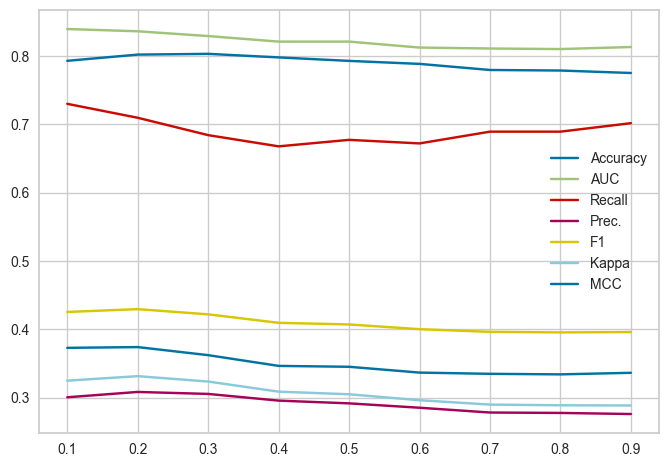

In [7]:
# start a loop
models = []
results = []

for i in np.arange(0.1,1,0.1):
    model = create_model('lightgbm', learning_rate = i)
    model_results = pull().loc[['Mean']]
    models.append(model)
    results.append(model_results)
    
results = pd.concat(results, axis=0)
results.index = np.arange(0.1,1,0.1)
results.plot()

In [448]:
lightgbm = create_model('lightgbm', cross_validation=False, learning_rate=0.1)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.7856,0.8375,0.7301,0.3007,0.4260,0.3212,0.3691


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [449]:
dt = create_model('dt', cross_validation=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.8183,0.6380,0.4075,0.2748,0.3282,0.2277,0.2336


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [450]:
xgboost = create_model('xgboost', cross_validation=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.8023,0.8325,0.6835,0.3133,0.4297,0.3295,0.3663


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [451]:
lr = create_model('lr', cross_validation=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.7640,0.8536,0.7969,0.2888,0.4239,0.3142,0.3784


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [452]:
svm = create_model('svm', cross_validation=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.7476,0.7699,0.7983,0.2740,0.4080,0.2934,0.3613


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

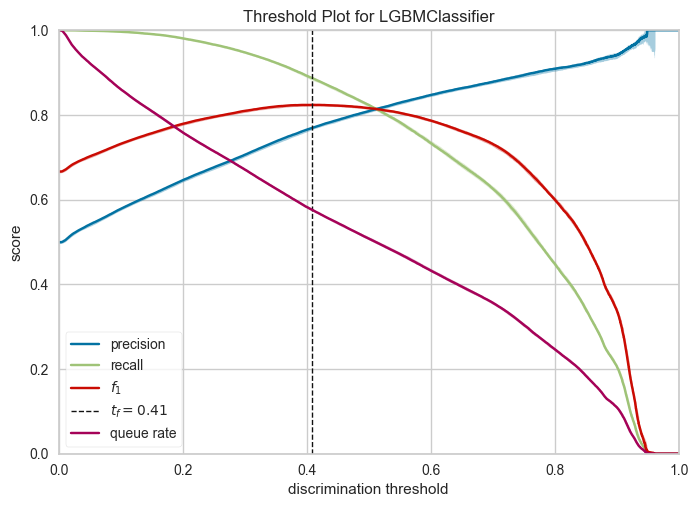

In [13]:
plot_model(lightgbm, plot = 'threshold')

In [148]:
adjust_threshold_lightgbm = create_model('lightgbm', cross_validation=False, learning_rate=0.1, probability_threshold = 0.54)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.8046,0.8375,0.7020,0.3194,0.4391,0.3403,0.3791


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [119]:
information = mimic_valid_ori[['subject_id','Age','gender','ethnicity','insurance', 'Time_since_ICU_admission']]

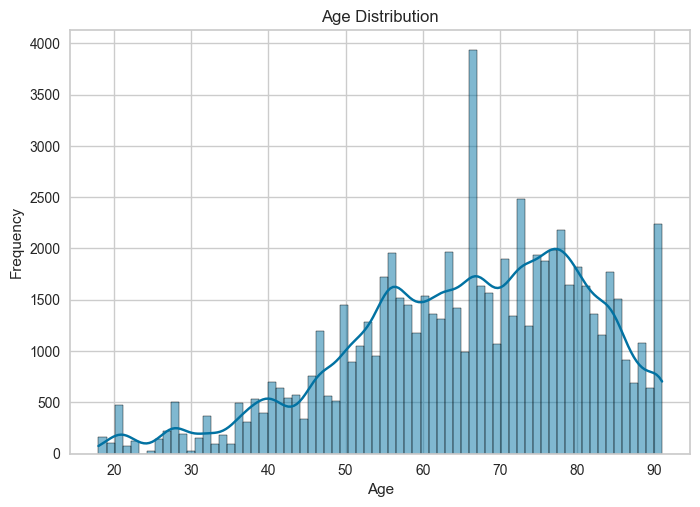

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data=information, x='Age', kde=True)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()

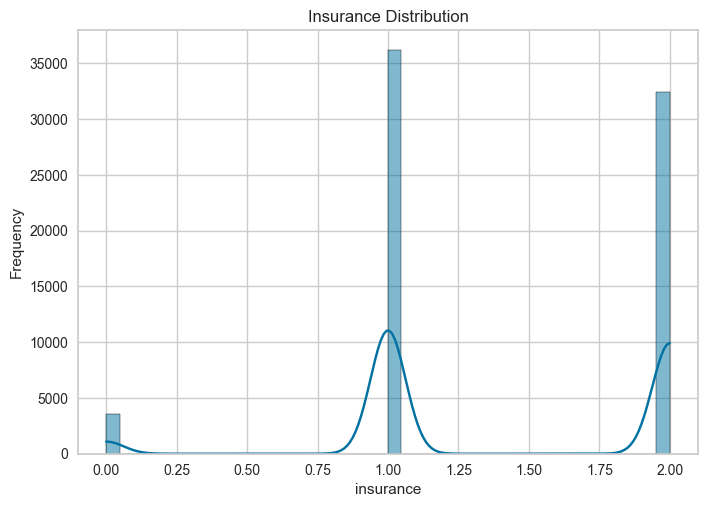

In [56]:
sns.histplot(data=information, x='insurance', kde=True)
plt.xlabel('insurance')
plt.ylabel('Frequency')
plt.title('Insurance Distribution')
plt.show()

In [126]:
import pandas as pd

# 나이를 10년 단위로 그룹화
age_groups = pd.cut(information['Age'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=['0-10', '18-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100'])

# 'Age_Group' 열을 데이터프레임에 추가
information['Age_Group'] = age_groups

In [453]:
test_data = mimic_valid_emb.drop(['subject_id', 'stay_id', 'hadm_id', 'Time_since_FirstCirc'], axis = 1)
predictions_1 = predict_model(lightgbm, data=test_data, raw_score=True, probability_threshold = 0.54)

In [454]:
predictions_2 = predict_model(dt, data=test_data, raw_score=True)
predictions_3 = predict_model(xgboost, data=test_data, raw_score=True)
predictions_4 = predict_model(lr, data=test_data, raw_score=True)
predictions_5 = predict_model(svm, data=test_data, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.8183,0.6380,0.4075,0.2748,0.3282,0.2277,0.2336


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.8023,0.8325,0.6835,0.3133,0.4297,0.3295,0.3663


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7640,0.8536,0.7969,0.2888,0.4239,0.3142,0.3784


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.7476,0.7699,0.7983,0.2740,0.4080,0.2934,0.3613


In [202]:
def make_mapper(predictions):    
    #AGE
    age = information[['subject_id', 'Age_Group']]
    dict_age = age.set_index('subject_id')['Age_Group'].to_dict()

    predictions['Age_Group'] = mimic_valid_ori['subject_id'].values.copy()
    predictions['Age_Group']  = predictions['Age_Group'].map(dict_age)

    #Insurance
    insurance = information[['subject_id', 'insurance']]
    dict_ins = insurance.set_index('subject_id')['insurance'].to_dict()

    predictions['insurance_Group'] = mimic_valid_ori['subject_id'].values.copy()
    predictions['insurance_Group']  = predictions['insurance_Group'].map(dict_ins)

    #Gender
    gender = information[['subject_id', 'gender']]
    dict_gender = gender.set_index('subject_id')['gender'].to_dict()

    predictions['gender_Group'] = mimic_valid_ori['subject_id'].values.copy()
    predictions['gender_Group']  = predictions['gender_Group'].map(dict_gender)

    #Ethnicity
    ethnicity = information[['subject_id', 'ethnicity']]
    dict_ethnicity = ethnicity.set_index('subject_id')['ethnicity'].to_dict()

    predictions['ethnicity_Group'] = mimic_valid_ori['subject_id'].values.copy()
    predictions['ethnicity_Group']  = predictions['ethnicity_Group'].map(dict_ethnicity)
    
    return predictions

In [205]:
predictions_1 = make_mapper(predictions_1)
predictions_2 = make_mapper(predictions_2)
predictions_3 = make_mapper(predictions_3)
predictions_4 = make_mapper(predictions_4)
predictions_5 = make_mapper(predictions_5)

In [206]:
ethnicities = ['AMERICAN INDIAN/ALASKA NATIVE', 'ASIAN', 'ASIAN - ASIAN INDIAN',
    'ASIAN - CHINESE', 'ASIAN - KOREAN', 'ASIAN - SOUTH EAST ASIAN',
    'BLACK/AFRICAN', 'BLACK/AFRICAN AMERICAN', 'BLACK/CAPE VERDEAN',
    'BLACK/CARIBBEAN ISLAND', 'HISPANIC OR LATINO',
    'HISPANIC/LATINO - CENTRAL AMERICAN', 'HISPANIC/LATINO - COLUMBIAN',
    'HISPANIC/LATINO - CUBAN', 'HISPANIC/LATINO - DOMINICAN',
    'HISPANIC/LATINO - GUATEMALAN', 'HISPANIC/LATINO - HONDURAN',
    'HISPANIC/LATINO - MEXICAN', 'HISPANIC/LATINO - PUERTO RICAN',
    'HISPANIC/LATINO - SALVADORAN', 'MULTIPLE RACE/ETHNICITY',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'OTHER',
    'PATIENT DECLINED TO ANSWER', 'PORTUGUESE', 'SOUTH AMERICAN',
    'UNABLE TO OBTAIN', 'UNKNOWN', 'WHITE', 'WHITE - BRAZILIAN',
    'WHITE - EASTERN EUROPEAN', 'WHITE - OTHER EUROPEAN', 'WHITE - RUSSIAN'
]

ethnicity_dict = {idx: ethnicity for idx, ethnicity in enumerate(ethnicities)}

insurance = ['Medicaid', 'Medicare', 'Other']
insurance_dict = {idx: ins for idx, ins in enumerate(insurance)}

form  = ['Female', 'Male']
gen_dict = {idx: gen for idx, gen in enumerate(form)}


def group_mapper(predictions):

    predictions['gender_Group']  = predictions['gender_Group'].map(gen_dict)
    predictions['insurance_Group']  = predictions['insurance_Group'].map(insurance_dict)
    predictions['ethnicity_Group']  = predictions['ethnicity_Group'].map(ethnicity_dict)
    
    return predictions

predictions_1 = group_mapper(predictions_1)
predictions_2 = group_mapper(predictions_2)
predictions_3 = group_mapper(predictions_3)
predictions_4 = group_mapper(predictions_4)
predictions_5 = group_mapper(predictions_5)

In [79]:
def IoC(precision, recall, beta):
    score = (1+beta**2)*precision*recall/((beta**2)*precision+recall)
    return score

In [285]:
lgbmioc = IoC(precision=0.3194, recall=0.7020, beta= 2)
dtioc = IoC(precision=0.2748, recall=0.4075, beta= 2)
xgbioc = IoC(precision=0.3133, recall=0.6835, beta= 2)
lrioc = IoC(precision=0.2888, recall=0.7969, beta= 2)
svmioc = IoC(precision=0.2740, recall=0.7983, beta= 2)

In [284]:
print('ioc(beta=1.5)')
print('light gbm: ', lgbmioc)
print('dtL ', dtioc)
print('xgbioc', xgbioc)
print('lrioc', lrioc)
print('svmioc', svmioc)

ioc(beta=1.5)
light gbm:  0.51294203357618
dtL  0.35478480210567365
xgbioc 0.5012563066064066
lrioc 0.5170182760765881
svmioc 0.5024640585241731


In [286]:
print('ioc(beta=2)')
print('light gbm: ', lgbmioc)
print('dtL ', dtioc)
print('xgbioc', xgbioc)
print('lrioc', lrioc)
print('svmioc', svmioc)

ioc(beta=2)
light gbm:  0.5663234996969083
dtL  0.37161014136855375
xgbioc 0.5528490473485825
lrioc 0.5894798422211976
svmioc 0.57734836087209


In [287]:
(lgbmioc + dtioc + xgbioc + lrioc + svmioc)/5

0.5315221783014664

In [458]:
predictions_model1 = predictions_1.copy()
predictions_model2 = predictions_2.copy()
predictions_model3 = predictions_3.copy()
predictions_model4 = predictions_4.copy()
predictions_model5 = predictions_5.copy()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


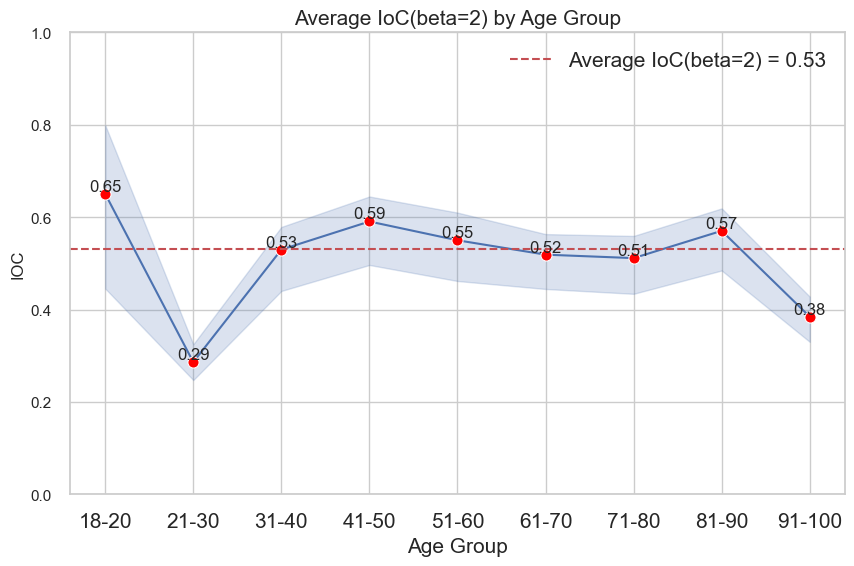

In [291]:
from sklearn.metrics import recall_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt

predictions_model1 = predictions_1.copy()
predictions_model2 = predictions_2.copy()
predictions_model3 = predictions_3.copy()
predictions_model4 = predictions_4.copy()
predictions_model5 = predictions_5.copy()

# 각 모델의 예측 결과를 저장하는 데이터프레임 목록 생성
model_predictions = [predictions_model1, predictions_model2, predictions_model3, predictions_model4, predictions_model5]
model_names = ['lgbm', 'dt', 'xgboost', 'lr', 'svm']

# 빈 리스트를 만들어 나이 그룹과 해당 그룹의 IOC 값을 저장
age_groups = []
IOC_scores = []
model_labels = []

# 모델 목록을 반복하면서 각 모델에 대한 성능 메트릭 계산
for model_name, predictions in zip(model_names, model_predictions):
    data = predictions[['classes', 'prediction_label', 'Age_Group']]
    unique_age_groups = data['Age_Group'].unique()
    unique_age_groups = sorted(unique_age_groups)
    
    for age_group in unique_age_groups:
        subset = data[data['Age_Group'] == age_group]
        recall = recall_score(subset['classes'], subset['prediction_label'])
        precision = precision_score(subset['classes'], subset['prediction_label'])
        ioc = IoC(precision, recall, 2)
        age_groups.append(age_group)
        IOC_scores.append(ioc)
        model_labels.append(model_name)

# 데이터프레임으로 변환
data = pd.DataFrame({'Age_Group': age_groups, 'IOC': IOC_scores, 'Model': model_labels})

# 그래프 그리기 (포인트 플롯)
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='Age_Group', y='IOC', marker='o', markersize=8, markerfacecolor='red')
plt.xlabel('Age Group', fontsize = 15)
plt.ylabel('IOC')
plt.title('Average IoC(beta=2) by Age Group', fontsize=15)
plt.xticks(rotation=0, fontsize = 15)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='upper right')  # 범례 표시

totalIOC = 0.5315221783014664
plt.axhline(y=totalIOC, color='r', linestyle='--', label=f'Average IoC(beta=2) = {totalIOC:.2f}')
plt.legend(loc='upper right', fontsize = 15)  # 범례 표시
# 각 그룹별로 IOC의 평균값을 계산하고 노출
average_ioc = data.groupby(['Age_Group'])['IOC'].mean().reset_index()
for i, row in average_ioc.iterrows():
    x_position = unique_age_groups.index(row['Age_Group'])
    plt.text(x_position, row['IOC'], f"{row['IOC']:.2f}", ha='center', va='bottom')

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


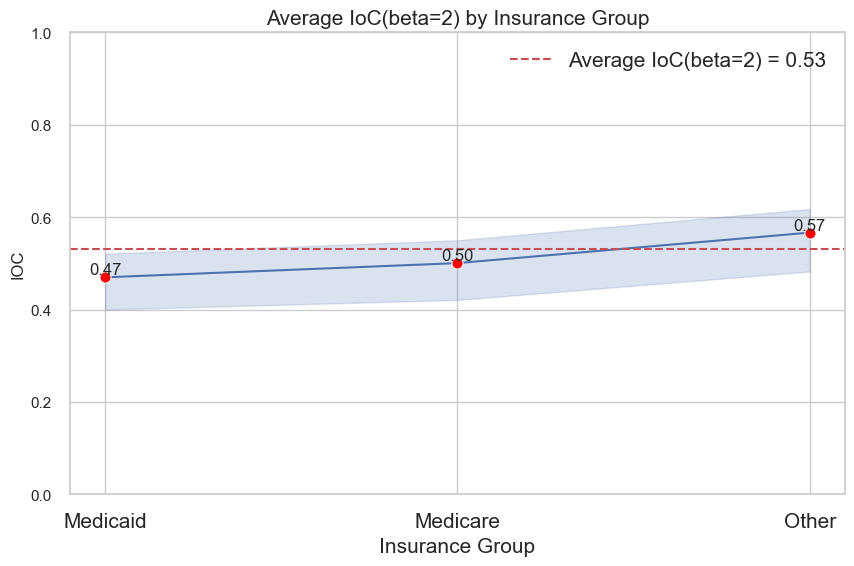

In [292]:
#insurance_Group

predictions_model1 = predictions_1.copy()
predictions_model2 = predictions_2.copy()
predictions_model3 = predictions_3.copy()
predictions_model4 = predictions_4.copy()
predictions_model5 = predictions_5.copy()

# 각 모델의 예측 결과를 저장하는 데이터프레임 목록 생성
model_predictions = [predictions_model1, predictions_model2, predictions_model3, predictions_model4, predictions_model5]
model_names = ['lgbm', 'dt', 'xgboost', 'lr', 'svm']

# 빈 리스트를 만들어 나이 그룹과 해당 그룹의 IOC 값을 저장
age_groups = []
IOC_scores = []
model_labels = []

# 모델 목록을 반복하면서 각 모델에 대한 성능 메트릭 계산
for model_name, predictions in zip(model_names, model_predictions):
    data = predictions[['classes', 'prediction_label', 'insurance_Group']]
    unique_age_groups = data['insurance_Group'].unique()
    unique_age_groups = sorted(unique_age_groups)
    
    for age_group in unique_age_groups:
        subset = data[data['insurance_Group'] == age_group]
        recall = recall_score(subset['classes'], subset['prediction_label'])
        precision = precision_score(subset['classes'], subset['prediction_label'])
        ioc = IoC(precision, recall, 2)
        age_groups.append(age_group)
        IOC_scores.append(ioc)
        model_labels.append(model_name)

# 데이터프레임으로 변환
data = pd.DataFrame({'insurance_Group': age_groups, 'IOC': IOC_scores, 'Model': model_labels})

# 그래프 그리기 (포인트 플롯)
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='insurance_Group', y='IOC', marker='o', markersize=8, markerfacecolor='red')
plt.xlabel('Insurance Group', fontsize=15)
plt.ylabel('IOC')
plt.title('Average IoC(beta=2) by Insurance Group', fontsize=15)
plt.xticks(rotation=0, fontsize=15)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='upper right', fontsize=15)  # 범례 표시

totalIOC = 0.5315221783014664
plt.axhline(y=totalIOC, color='r', linestyle='--', label=f'Average IoC(beta=2) = {totalIOC:.2f}')
plt.legend(loc='upper right', fontsize=15)  # 범례 표시
# 각 그룹별로 IOC의 평균값을 계산하고 노출
average_ioc = data.groupby(['insurance_Group'])['IOC'].mean().reset_index()
for i, row in average_ioc.iterrows():
    x_position = unique_age_groups.index(row['insurance_Group'])
    plt.text(x_position, row['IOC'], f"{row['IOC']:.2f}", ha='center', va='bottom')

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


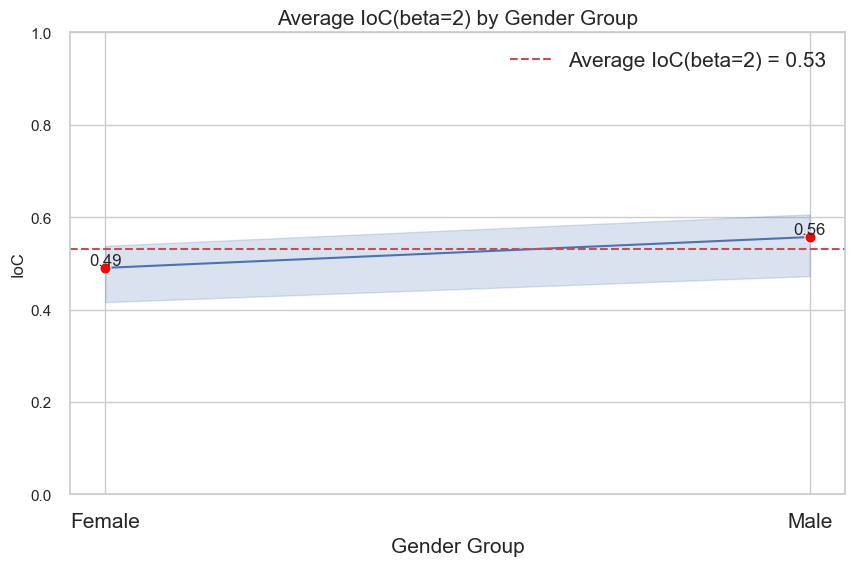

In [293]:
#gender_Group

predictions_model1 = predictions_1.copy()
predictions_model2 = predictions_2.copy()
predictions_model3 = predictions_3.copy()
predictions_model4 = predictions_4.copy()
predictions_model5 = predictions_5.copy()

# 각 모델의 예측 결과를 저장하는 데이터프레임 목록 생성
model_predictions = [predictions_model1, predictions_model2, predictions_model3, predictions_model4, predictions_model5]
model_names = ['lgbm', 'dt', 'xgboost', 'lr', 'svm']

# 빈 리스트를 만들어 나이 그룹과 해당 그룹의 IOC 값을 저장
age_groups = []
IOC_scores = []
model_labels = []

# 모델 목록을 반복하면서 각 모델에 대한 성능 메트릭 계산
for model_name, predictions in zip(model_names, model_predictions):
    data = predictions[['classes', 'prediction_label', 'gender_Group']]
    unique_age_groups = data['gender_Group'].unique()
    unique_age_groups = sorted(unique_age_groups)
    
    for age_group in unique_age_groups:
        subset = data[data['gender_Group'] == age_group]
        recall = recall_score(subset['classes'], subset['prediction_label'])
        precision = precision_score(subset['classes'], subset['prediction_label'])
        ioc = IoC(precision, recall, 2)
        age_groups.append(age_group)
        IOC_scores.append(ioc)
        model_labels.append(model_name)

# 데이터프레임으로 변환
data = pd.DataFrame({'gender_Group': age_groups, 'IOC': IOC_scores, 'Model': model_labels})

# 그래프 그리기 (포인트 플롯)
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='gender_Group', y='IOC', marker='o', markersize=8, markerfacecolor='red')
plt.xlabel('Gender Group', fontsize=15)
plt.ylabel('IoC')
plt.title('Average IoC(beta=2) by Gender Group', fontsize=15)
plt.xticks(rotation=0, fontsize=15)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='upper right')  # 범례 표시

totalIOC = 0.5315221783014664
plt.axhline(y=totalIOC, color='r', linestyle='--', label=f'Average IoC(beta=2) = {totalIOC:.2f}')
plt.legend(loc='upper right', fontsize= 15)  # 범례 표시
# 각 그룹별로 IOC의 평균값을 계산하고 노출
average_ioc = data.groupby(['gender_Group'])['IOC'].mean().reset_index()
for i, row in average_ioc.iterrows():
    x_position = unique_age_groups.index(row['gender_Group'])
    plt.text(x_position, row['IOC'], f"{row['IOC']:.2f}", ha='center', va='bottom')

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


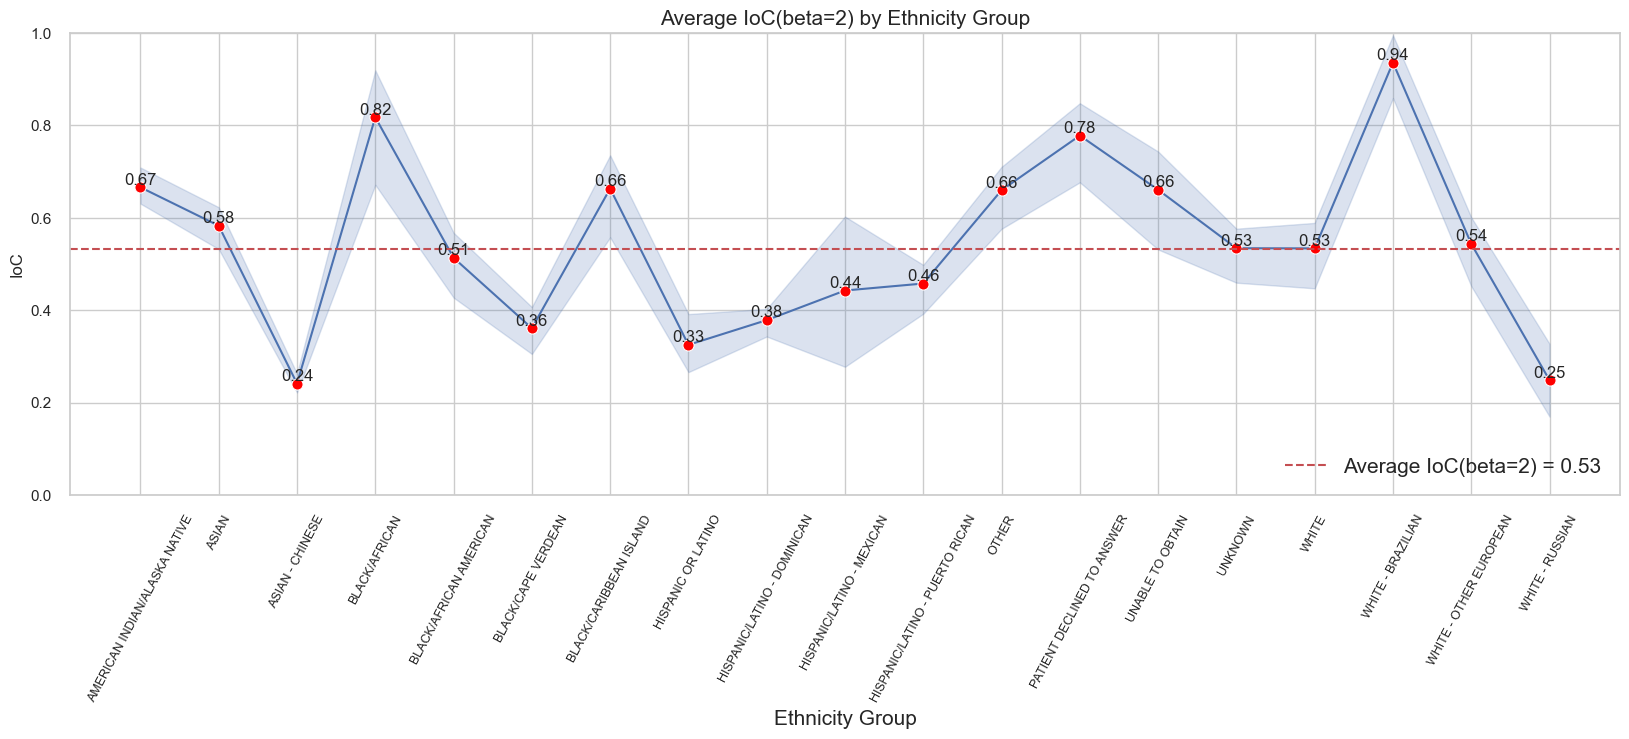

In [294]:
predictions_model1 = predictions_1.copy()
predictions_model2 = predictions_2.copy()
predictions_model3 = predictions_3.copy()
predictions_model4 = predictions_4.copy()
predictions_model5 = predictions_5.copy()

# 각 모델의 예측 결과를 저장하는 데이터프레임 목록 생성
model_predictions = [predictions_model1, predictions_model2, predictions_model3, predictions_model4, predictions_model5]
model_names = ['lgbm', 'dt', 'xgboost', 'lr', 'svm']

# 빈 리스트를 만들어 나이 그룹과 해당 그룹의 IOC 값을 저장
age_groups = []
IOC_scores = []
model_labels = []

# 모델 목록을 반복하면서 각 모델에 대한 성능 메트릭 계산
for model_name, predictions in zip(model_names, model_predictions):
    data = predictions[['classes', 'prediction_label', 'ethnicity_Group']]
    unique_age_groups = ['AMERICAN INDIAN/ALASKA NATIVE', 'ASIAN', 'ASIAN - CHINESE',
       'BLACK/AFRICAN', 'BLACK/AFRICAN AMERICAN', 'BLACK/CAPE VERDEAN',
       'BLACK/CARIBBEAN ISLAND', 'HISPANIC OR LATINO',
       'HISPANIC/LATINO - DOMINICAN', 'HISPANIC/LATINO - MEXICAN',
       'HISPANIC/LATINO - PUERTO RICAN', 'OTHER',
       'PATIENT DECLINED TO ANSWER', 'UNABLE TO OBTAIN', 'UNKNOWN',
       'WHITE', 'WHITE - BRAZILIAN', 'WHITE - OTHER EUROPEAN',
       'WHITE - RUSSIAN']
    unique_age_groups = sorted(unique_age_groups)
    
    for age_group in unique_age_groups:
        subset = data[data['ethnicity_Group'] == age_group]
        recall = recall_score(subset['classes'], subset['prediction_label'])
        precision = precision_score(subset['classes'], subset['prediction_label'])
        ioc = IoC(precision, recall, 2)
        age_groups.append(age_group)
        IOC_scores.append(ioc)
        model_labels.append(model_name)

# 데이터프레임으로 변환
data = pd.DataFrame({'ethnicity_Group': age_groups, 'IOC': IOC_scores, 'Model': model_labels})
plt.figure(figsize=(20, 6))
# 그래프 그리기 (포인트 플롯)
sns.lineplot(data=data, x='ethnicity_Group', y='IOC', marker='o', markersize=8, markerfacecolor='red')
plt.xlabel('Ethnicity Group',fontsize=15)
plt.ylabel('IoC')
plt.title('Average IoC(beta=2) by Ethnicity Group', fontsize=15)
plt.xticks(rotation=62,fontsize=9)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='upper right')  # 범례 표시

# totalIOC = 0.47769309537780436
plt.axhline(y=totalIOC, color='r', linestyle='--', label=f'Average IoC(beta=2) = {totalIOC:.2f}')
plt.legend(loc='lower right', fontsize=15)  # 범례 표시
# 각 그룹별로 IOC의 평균값을 계산하고 노출
average_ioc = data.groupby(['ethnicity_Group'])['IOC'].mean().reset_index()
for i, row in average_ioc.iterrows():
    x_position = unique_age_groups.index(row['ethnicity_Group'])
    plt.text(x_position, row['IOC'], f"{row['IOC']:.2f}", ha='center', va='bottom')

plt.show()

In [327]:
# 나이를 10년 단위로 그룹화
time_groups = pd.cut(information['Time_since_ICU_admission'], bins=[0, 1, 2, 4, 8, 24, 48, 71.5], labels=['1h', '2h', '4h', '8h', '24h', '2d', '3d~'])
# time_groups = pd.cut(information['Time_since_ICU_admission'], bins=[0, 1, 2, 4, 8, 24, 48, 71.5], labels=['1h', '2h', '4h', '8h', '24h', '2d~'])

# 'Age_Group' 열을 데이터프레임에 추가
information['time_Group'] = time_groups

predictions_model1['time_Group'] = time_groups
predictions_model2['time_Group'] = time_groups
predictions_model3['time_Group'] = time_groups
predictions_model4['time_Group'] = time_groups
predictions_model5['time_Group'] = time_groups

In [ ]:
unique_time_groups = ['1h', '2h', '4h', '8h', '24h', '2d', '3d~']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


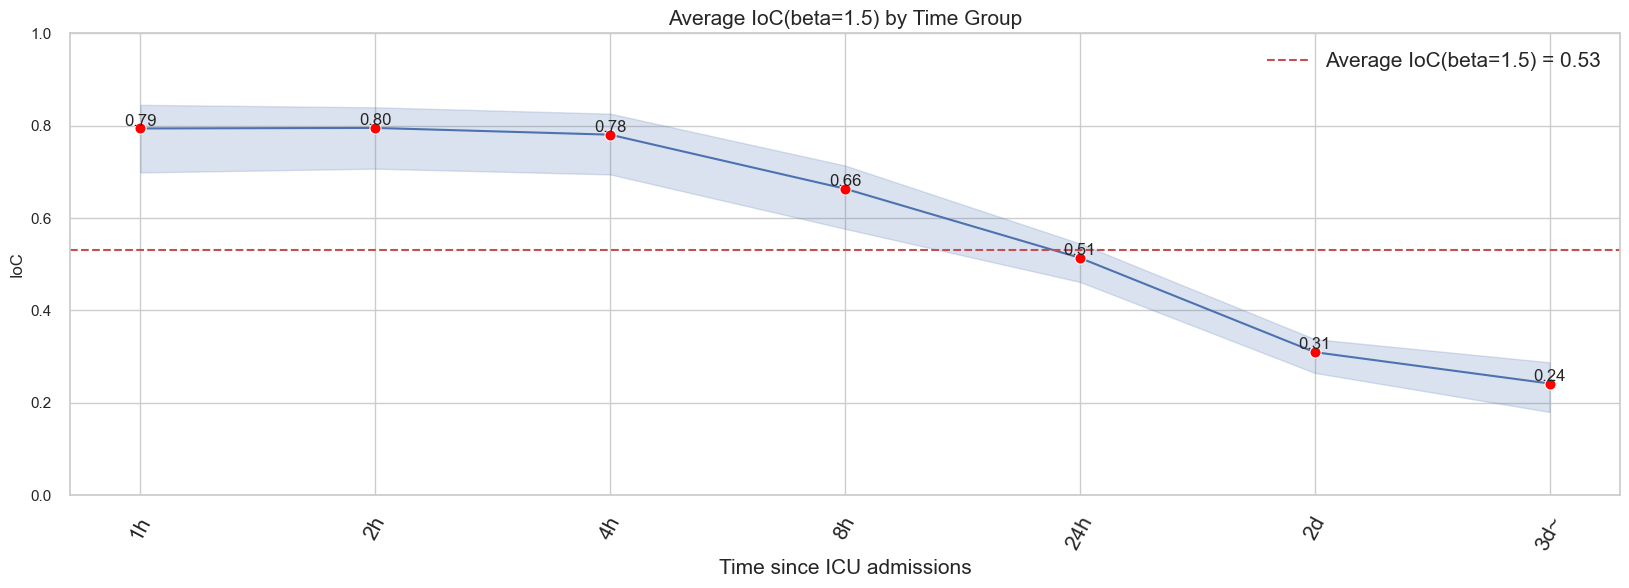

In [330]:
# predictions_model1 = predictions_1.copy()
# predictions_model2 = predictions_2.copy()
# predictions_model3 = predictions_3.copy()
# predictions_model4 = predictions_4.copy()
# predictions_model5 = predictions_5.copy()

# 각 모델의 예측 결과를 저장하는 데이터프레임 목록 생성
model_predictions = [predictions_model1, predictions_model2, predictions_model3, predictions_model4, predictions_model5]
model_names = ['lgbm', 'dt', 'xgboost', 'lr', 'svm']

# 빈 리스트를 만들어 나이 그룹과 해당 그룹의 IOC 값을 저장
age_groups = []
IOC_scores = []
model_labels = []

# 모델 목록을 반복하면서 각 모델에 대한 성능 메트릭 계산
for model_name, predictions in zip(model_names, model_predictions):
    data = predictions[['classes', 'prediction_label', 'time_Group']]
    unique_age_groups = ['1h', '2h', '4h', '8h', '24h', '2d', '3d~']
    # unique_age_groups = sorted(unique_age_groups)
    
    for age_group in unique_age_groups:
        subset = data[data['time_Group'] == age_group]
        recall = recall_score(subset['classes'], subset['prediction_label'])
        precision = precision_score(subset['classes'], subset['prediction_label'])
        ioc = IoC(precision, recall, 1.5)
        age_groups.append(age_group)
        IOC_scores.append(ioc)
        model_labels.append(model_name)

# 데이터프레임으로 변환
data = pd.DataFrame({'time_Group': age_groups, 'IOC': IOC_scores, 'Model': model_labels})
plt.figure(figsize=(20, 6))
# 그래프 그리기 (포인트 플롯)
sns.lineplot(data=data, x='time_Group', y='IOC', marker='o', markersize=8, markerfacecolor='red')
# sns.lineplot(x=data['time_Group'], y=['1h(428/677)', '2h(367/591)', '4h(397/996)', '8h(773/1745)', '24h(2256/8780)', '2d(2184/23700)', '3d~(1029/34297)'], marker='o', markersize=8, markerfacecolor='red')
plt.xlabel('Time since ICU admissions', fontsize=15)
plt.ylabel('IoC')
plt.title('Average IoC(beta=1.5) by Time Group', fontsize=15)
plt.xticks(rotation=62,fontsize=15)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='upper right')  # 범례 표시

# totalIOC = 0.47769309537780436
plt.axhline(y=totalIOC, color='r', linestyle='--', label=f'Average IoC(beta=1.5) = {totalIOC:.2f}')
plt.legend(loc='upper right', fontsize=15)  # 범례 표시
# 각 그룹별로 IOC의 평균값을 계산하고 노출
average_ioc = data.groupby(['time_Group'])['IOC'].mean().reset_index()
for i, row in average_ioc.iterrows():
    x_position = unique_age_groups.index(row['time_Group'])
    plt.text(x_position, row['IOC'], f"{row['IOC']:.2f}", ha='center', va='bottom')

plt.show()

In [ ]:
['1h(428/677)', '2h(367/591)', '4h(397/996)', '8h(773/1745)', '24h(2256/8780)', '2d(2184/23700)', '3d~(1029/34297)']

In [307]:
predictions_model4.groupby(['time_Group', 'classes']).count()[['prediction_label']]

prediction_label
time_Group classes                  
1h         0                     249
           1                     428
2h         0                     224
           1                     367
4h         0                     397
           1                     599
8h         0                     972
           1                     773
24h        0                    6524
           1                    2256
2d         0                   21516
           1                    2184
3d~        0                   34297
           1                    1029

In [303]:
predictions_model4.groupby(['Age_Group', 'classes']).count()[['prediction_label']]

prediction_label
Age_Group classes                  
18-20     0                     260
          1                      12
21-30     0                    1660
          1                     124
31-40     0                    2931
          1                     399
41-50     0                    5669
          1                     905
51-60     0                   11843
          1                    1699
61-70     0                   13863
          1                    1397
71-80     0                   16642
          1                    1778
81-90     0                    9502
          1                    1250
91-100    0                    1943
          1                     299

In [346]:
(16/(542+16))

0.02867383512544803

In [308]:
predictions_model4.groupby(['ethnicity_Group', 'classes']).count()[['prediction_label']]

prediction_label
ethnicity_Group                           classes                  
AMERICAN INDIAN/ALASKA NATIVE             0                      86
                                          1                      20
ASIAN                                     0                     679
                                          1                      73
ASIAN - ASIAN INDIAN                      0                       2
ASIAN - CHINESE                           0                     542
                                          1                      16
ASIAN - SOUTH EAST ASIAN                  0                     358
BLACK/AFRICAN                             0                     154
                                          1                       8
BLACK/AFRICAN AMERICAN                    0                    4233
                                          1                     721
BLACK/CAPE VERDEAN                        0                     488
                                          1                      22
BLACK/CARIBBEAN ISLAND                    0                     522
                                          1                      60
HISPANIC OR LATINO                        0                     926
                                          1                      78
HISPANIC/LATINO - COLUMBIAN               0                      96
HISPANIC/LATINO - DOMINICAN               0                     447
                                          1                      47
HISPANIC/LATINO - GUATEMALAN              1                       6
HISPANIC/LATINO - HONDURAN                0                     120
HISPANIC/LATINO - MEXICAN                 0                       2
                                          1                      38
HISPANIC/LATINO - PUERTO RICAN            0                     875
                                          1                     131
HISPANIC/LATINO - SALVADORAN              0                      20
NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER 0                      60
OTHER                                     0                    1811
                                          1                     353
PATIENT DECLINED TO ANSWER                0                     359
                                          1                      99
PORTUGUESE                                0                     136
SOUTH AMERICAN                            0                      52
                                          1                       4
UNABLE TO OBTAIN                          0                    1136
                                          1                     152
UNKNOWN                                   0                    8045
                                          1                     897
WHITE                                     0                   40855
                                          1                    4977
WHITE - BRAZILIAN                         0                      90
                                          1                       8
WHITE - EASTERN EUROPEAN                  0                     200
WHITE - OTHER EUROPEAN                    0                    1248
                                          1                      64
WHITE - RUSSIAN                           0                     771
                                          1                      89

In [343]:
(28451/(28451+3863))*100

88.0454292257226

In [344]:
100-88.04

11.959999999999994

In [310]:
predictions_model4.groupby(['gender_Group', 'classes']).count()[['prediction_label']]

prediction_label
gender_Group classes                  
Female       0                   28315
             1                    2947
Male         0                   35998
             1                    4916

In [312]:
predictions_model4.groupby(['insurance_Group', 'classes']).count()[['prediction_label']]

prediction_label
insurance_Group classes                  
Medicaid        0                    3255
                1                     297
Medicare        0                   32607
                1                    3703
Other           0                   28451
                1                    3863

In [467]:
predictions_model1['Time_since_FirstCirc'] = information['Time_since_FirstCirc'].values.copy()
predictions_model2['Time_since_FirstCirc'] = information['Time_since_FirstCirc'].values.copy()
predictions_model3['Time_since_FirstCirc'] = information['Time_since_FirstCirc'].values.copy()
predictions_model4['Time_since_FirstCirc'] = information['Time_since_FirstCirc'].values.copy()
predictions_model5['Time_since_FirstCirc'] = information['Time_since_FirstCirc'].values.copy()

for_newplot_1 = predictions_model1[~(predictions_model1['Time_since_FirstCirc']=='blank')].copy()
for_newplot_2 = predictions_model2[~(predictions_model2['Time_since_FirstCirc']=='blank')].copy()
for_newplot_3 = predictions_model3[~(predictions_model3['Time_since_FirstCirc']=='blank')].copy()
for_newplot_4 = predictions_model4[~(predictions_model4['Time_since_FirstCirc']=='blank')].copy()
for_newplot_5 = predictions_model5[~(predictions_model5['Time_since_FirstCirc']=='blank')].copy()

for_newplot_1 = for_newplot_1[for_newplot_1['Time_since_FirstCirc']>=0]
for_newplot_2 = for_newplot_2[for_newplot_2['Time_since_FirstCirc']>=0]
for_newplot_3 = for_newplot_3[for_newplot_3['Time_since_FirstCirc']>=0]
for_newplot_4 = for_newplot_4[for_newplot_4['Time_since_FirstCirc']>=0]
for_newplot_5 = for_newplot_5[for_newplot_5['Time_since_FirstCirc']>=0]

alarm_groups = pd.cut(for_newplot_1['Time_since_FirstCirc'],bins = [0, 2, 4, 8, 12, 24], labels=['0h', '2h', '4h', '8h', '12h'])
for_newplot_1['alarm_Group'] = alarm_groups
for_newplot_2['alarm_Group'] = alarm_groups
for_newplot_3['alarm_Group'] = alarm_groups
for_newplot_4['alarm_Group'] = alarm_groups
for_newplot_5['alarm_Group'] = alarm_groups

In [472]:
for_newplot_1

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,classes,prediction_label,prediction_score_0,prediction_score_1,Time_since_FirstCirc,alarm_Group
126,1.347630,1.287913,1.287377,1.306322,-4.163707e-07,-0.000016,0.822131,1.221230,0.027328,-0.000004,...,-0.000007,1.312402,0.008168,-0.000022,0,1,0.0544,0.9456,64.0,NaN
127,1.346946,1.287164,1.286710,1.305612,-4.064723e-07,-0.000016,0.822485,1.220607,0.028540,-0.000004,...,-0.000007,1.311711,0.008152,-0.000022,0,1,0.0544,0.9456,63.5,NaN
128,1.342793,1.285441,1.285571,1.305617,-6.151022e-07,-0.000018,0.802866,1.216284,0.002208,-0.000004,...,-0.000007,1.311060,0.008380,-0.000022,0,1,0.0526,0.9474,63.0,NaN
129,1.342121,1.284698,1.284885,1.304881,-6.047933e-07,-0.000018,0.803207,1.215676,0.003385,-0.000004,...,-0.000007,1.310345,0.008363,-0.000022,0,1,0.0502,0.9498,62.5,NaN
130,1.349552,1.290822,1.290388,1.310092,-5.408635e-07,-0.000017,0.813449,1.222452,0.012080,-0.000004,...,-0.000007,1.316228,0.008332,-0.000022,0,1,0.0544,0.9456,62.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71779,0.751257,0.712672,0.720531,0.720515,1.926968e-04,-0.000009,0.438643,0.674051,-0.000082,-0.000001,...,-0.000005,0.728258,0.002429,-0.000014,1,1,0.1005,0.8995,6.5,4h
72020,0.486855,0.471343,0.501480,0.506437,1.409696e-04,-0.000016,0.176400,0.423959,-0.001679,-0.000002,...,-0.000005,0.498669,0.001787,-0.000014,1,1,0.1924,0.8076,17.0,12h
72021,0.485768,0.470257,0.500355,0.505261,1.416773e-04,-0.000016,0.175942,0.422990,-0.001677,-0.000002,...,-0.000005,0.497507,0.001771,-0.000014,1,1,0.1924,0.8076,16.5,12h
72022,0.484681,0.469171,0.499229,0.504085,1.423852e-04,-0.000016,0.175484,0.422022,-0.001675,-0.000002,...,-0.000005,0.496344,0.001754,-0.000014,1,1,0.1924,0.8076,16.0,12h


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


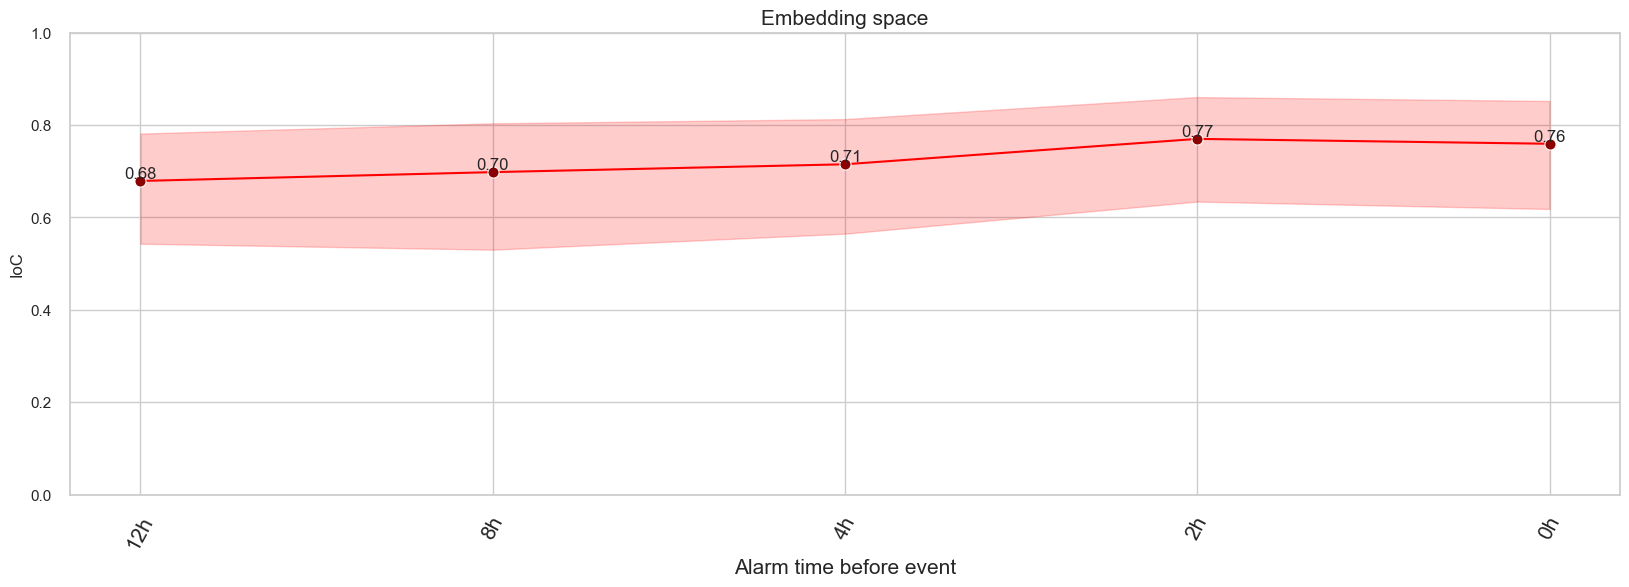

In [513]:
# 각 모델의 예측 결과를 저장하는 데이터프레임 목록 생성
model_predictions = [for_newplot_1, for_newplot_2, for_newplot_3, for_newplot_4, for_newplot_5]
model_names = ['lgbm', 'dt', 'xgboost', 'lr', 'svm']

# 빈 리스트를 만들어 나이 그룹과 해당 그룹의 IOC 값을 저장
age_groups = []
IOC_scores = []
model_labels = []

# 모델 목록을 반복하면서 각 모델에 대한 성능 메트릭 계산
for model_name, predictions in zip(model_names, model_predictions):
    data = predictions[['classes', 'prediction_label', 'alarm_Group']]
    unique_age_groups = ['12h', '8h', '4h',  '2h', '0h']
    # unique_age_groups = sorted(unique_age_groups)
    
    for age_group in unique_age_groups:
        subset = data[data['alarm_Group'] == age_group]
        recall = recall_score(subset['classes'], subset['prediction_label'])
        precision = precision_score(subset['classes'], subset['prediction_label'])
        ioc = IoC(precision, recall, 1.5)
        age_groups.append(age_group)
        IOC_scores.append(recall)
        model_labels.append(model_name)

# 데이터프레임으로 변환
data1 = pd.DataFrame({'alarm_Group': age_groups, 'IOC': IOC_scores, 'Model': model_labels})
plt.figure(figsize=(20, 6))
# 그래프 그리기 (포인트 플롯)
sns.lineplot(data=data1, x='alarm_Group', y='IOC', marker='o', markersize=8, markerfacecolor='darkred', color= 'red')
# sns.lineplot(x=data['time_Group'], y=['1h(428/677)', '2h(367/591)', '4h(397/996)', '8h(773/1745)', '24h(2256/8780)', '2d(2184/23700)', '3d~(1029/34297)'], marker='o', markersize=8, markerfacecolor='red')
plt.xlabel('Alarm time before event', fontsize=15)
plt.ylabel('IoC')
plt.title('Embedding space', fontsize=15)
plt.xticks(rotation=62,fontsize=15)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='upper right')  # 범례 표시

# totalIOC = 0.47769309537780436
# plt.axhline(y=totalIOC, color='r', linestyle='--', label=f'Average IoC(beta=1.5) = {totalIOC:.2f}')
# plt.legend(loc='upper right', fontsize=15)  # 범례 표시
# 각 그룹별로 IOC의 평균값을 계산하고 노출
average_ioc = data1.groupby(['alarm_Group'])['IOC'].mean().reset_index()
for i, row in average_ioc.iterrows():
    x_position = unique_age_groups.index(row['alarm_Group'])
    plt.text(x_position, row['IOC'], f"{row['IOC']:.2f}", ha='center', va='bottom')

plt.show()

In [497]:
data1

,alarm_Group,IOC,Model
0,12h,0.766774,lgbm
1,8h,0.792317,lgbm
2,4h,0.800393,lgbm
3,2h,0.858566,lgbm
4,0h,0.845890,lgbm
5,12h,0.500031,dt
6,8h,0.490398,dt
7,4h,0.548223,dt
8,2h,0.594548,dt
9,0h,0.569407,dt


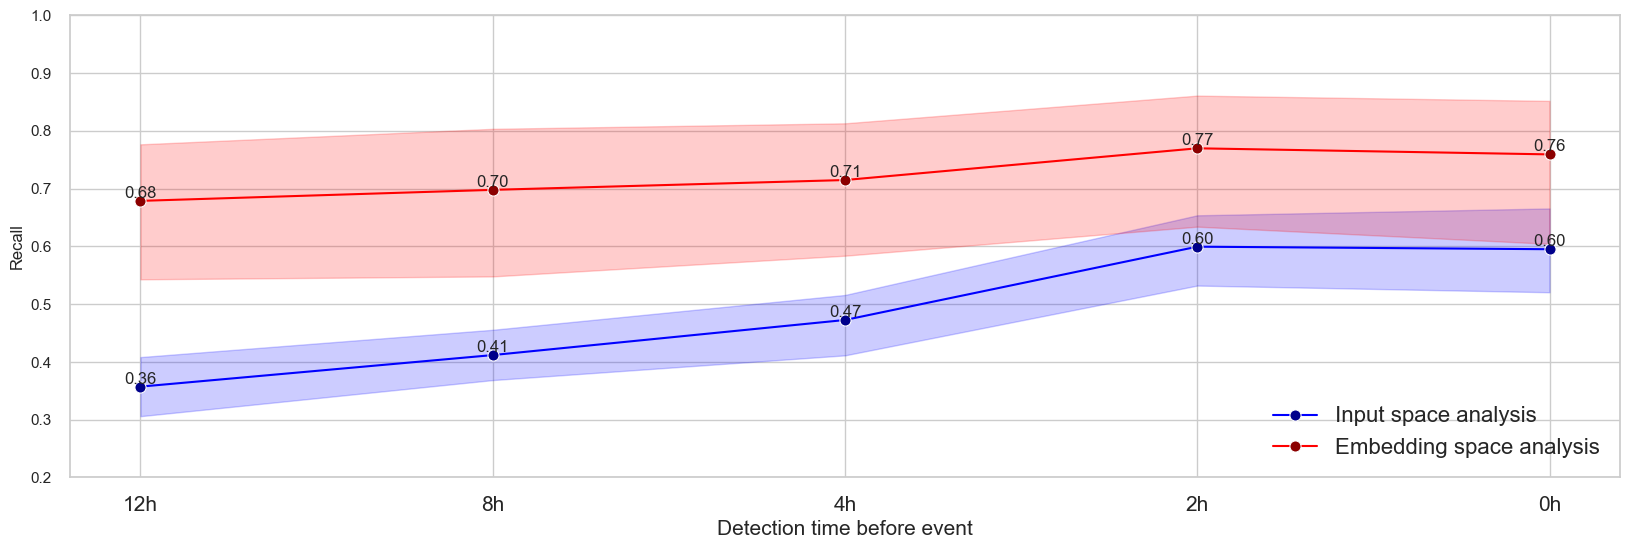

In [517]:
# 각 모델의 예측 결과를 저장하는 데이터프레임 목록 생성
model_predictions = [for_newplot_1_o, for_newplot_2_o, for_newplot_3_o, for_newplot_4_o, for_newplot_5_o]
model_names = ['lgbm', 'dt', 'xgboost', 'lr', 'svm']

# 빈 리스트를 만들어 나이 그룹과 해당 그룹의 IOC 값을 저장
age_groups = []
IOC_scores = []
model_labels = []

# 모델 목록을 반복하면서 각 모델에 대한 성능 메트릭 계산
for model_name, predictions in zip(model_names, model_predictions):
    data = predictions[['classes', 'prediction_label', 'alarm_Group']]
    unique_age_groups = ['12h', '8h', '4h',  '2h', '0h']
    # unique_age_groups = sorted(unique_age_groups)
    
    for age_group in unique_age_groups:
        subset = data[data['alarm_Group'] == age_group]
        recall = recall_score(subset['classes'], subset['prediction_label'])
        precision = precision_score(subset['classes'], subset['prediction_label'])
        ioc = IoC(precision, recall, 1.5)
        age_groups.append(age_group)
        IOC_scores.append(recall)
        model_labels.append(model_name)

# 데이터프레임으로 변환
data2 = pd.DataFrame({'alarm_Group': age_groups, 'IOC': IOC_scores, 'Model': model_labels})
plt.figure(figsize=(20, 6))
# 그래프 그리기 (포인트 플롯)
# sns.lineplot(data=data2, x='alarm_Group', y='IOC', marker='o', markersize=8, markerfacecolor='red')
sns.lineplot(data=data2, x='alarm_Group', y='IOC', marker='o', markersize=8, markerfacecolor='darkblue', color= 'blue', label='Input space analysis')
sns.lineplot(data=data1, x='alarm_Group', y='IOC', marker='o', markersize=8, markerfacecolor='darkred', color= 'red', label='Embedding space analysis')
# sns.lineplot(x=data['time_Group'], y=['1h(428/677)', '2h(367/591)', '4h(397/996)', '8h(773/1745)', '24h(2256/8780)', '2d(2184/23700)', '3d~(1029/34297)'], marker='o', markersize=8, markerfacecolor='red')
plt.xlabel('Detection time before event', fontsize=15)
plt.ylabel('Recall')
# plt.title('Input space', fontsize=15)
plt.xticks(rotation=0,fontsize=15)
plt.ylim(0.2, 1)
plt.grid(True)
plt.legend(loc='lower right',fontsize=16)  # 범례 표시

# totalIOC = 0.47769309537780436
# plt.axhline(y=totalIOC, color='r', linestyle='--', label=f'Average IoC(beta=1.5) = {totalIOC:.2f}')
# plt.legend(loc='upper right', fontsize=15)  # 범례 표시
# 각 그룹별로 IOC의 평균값을 계산하고 노출
average_ioc2 = data2.groupby(['alarm_Group'])['IOC'].mean().reset_index()
for i, row in average_ioc2.iterrows():
    x_position = unique_age_groups.index(row['alarm_Group'])
    plt.text(x_position, row['IOC'], f"{row['IOC']:.2f}", ha='center', va='bottom')
    
average_ioc1 = data1.groupby(['alarm_Group'])['IOC'].mean().reset_index()
for i, row in average_ioc1.iterrows():
    x_position = unique_age_groups.index(row['alarm_Group'])
    plt.text(x_position, row['IOC'], f"{row['IOC']:.2f}", ha='center', va='bottom')
plt.show()

In [510]:
for_newplot_1.groupby('alarm_Group').count()

,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,classes,prediction_label,prediction_score_0,prediction_score_1,Time_since_FirstCirc
alarm_Group,,,,,,,,,,,,,,,,,,,,,
0h,408,408,408,408,408,408,408,408,408,408,...,408,408,408,408,408,408,408,408,408,408
2h,796,796,796,796,796,796,796,796,796,796,...,796,796,796,796,796,796,796,796,796,796
4h,1450,1450,1450,1450,1450,1450,1450,1450,1450,1450,...,1450,1450,1450,1450,1450,1450,1450,1450,1450,1450
8h,1238,1238,1238,1238,1238,1238,1238,1238,1238,1238,...,1238,1238,1238,1238,1238,1238,1238,1238,1238,1238
12h,3088,3088,3088,3088,3088,3088,3088,3088,3088,3088,...,3088,3088,3088,3088,3088,3088,3088,3088,3088,3088
